<div style="background-color: #eee3d3">
<h1> 2-explore_data.ipynb </h1>
</div>

# Exploratory data analysis

---

### The aim of this notebook is to explore the peak table cleaned in the previous notebook (1-clean_RPpos_peakTable) with a few visualisations on target (here the Sample Group), missing values, distributions, ...

### Basic ckecklist :

#### Form analysis :
- __target__ : Groups
- __shape (rows & columns)__ : 186 rows (samples) x 337 columns (8 for metadata and 329 compounds)
- __features types__ :
    - metadata :
        - qualitative : 7 (SampleID, Groups, TypTumo, CaseHCCWide, EPICID, EPICBioID, AliquotID)
        - quantitative (int) : 1 (MatchCaseset)
    - variables (compounds and their adducts) :    
        - quantitative (float) : 329 (compounds)
- __missing values__ :
    - compounds can be in every sample (0% of missing values), in most of them or just in a few
    - the maximum of missing value for a variable is 49.5%, i.e. this variable is absent from 49.5% of the samples
    - (samples seem to be more easily separated with not too much missing values (logic))

#### Content analysis :
- __target visualisation__ :
    - ratio 1:1 (93 Cancer - 93 Healthy)
- __feature visualisation__ :
    - on the first 10 compounds, most of them follow a normal distribution
    - some of them follow a double normal distribution
    - maybe one distribution for each class (Healthy vs Cancer) --> hypothesis
- __relation features/target__ :
    - on the first 10 compounds, we don't see a clear difference of intensity between the Cancer and Healthy samples --> previous hypothesis rejected on these compounds --> may be true of others
- __relation features/features__ : strong correlations between some of the features --> need to reduce the dimension for further analysis

# Import modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

import plotly.express as px
from sklearn.decomposition import PCA

import cimcb_lite as cb

In [2]:
# Tune the visual settings for figures in seaborn
sns.set_context(
    "notebook", font_scale=1.2, rc={"figure.figsize": (8, 6), "axes.titlesize": 15}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 8, 6

sns.set_theme(style="darkgrid")

# Import useful functions

In [3]:
import re
pwd = ! pwd
pwd = re.sub('notebooks', '', pwd[0])

import sys
sys.path.append(pwd + 'bin/')

from explore_data_functions import *

# Import transformed peak table and create variable X (peakTable without metadata columns)

In [4]:
peakTable = pd.read_csv(pwd + 'data/peakTable/original_peak_table/peakTable_HILIC_POS_remove_corr.csv', sep=',', decimal='.', na_values='NA')
peakTable.head()

SampleID    Groups  MatchCaseset   TypTumo CaseHCCWide          EPICID  \
0  LivCan_153  Incident            82       HCC         Yes  41____41041872   
1  LivCan_154  Non-case            82       NaN          No  41____41046868   
2  LivCan_267  Incident           427       HCC         Yes  41____41074588   
3  LivCan_268  Non-case           427       NaN          No  41____41089214   
4  LivCan_299  Incident           376  HCC_Wide         Yes  21____21103888   

        EPICBioID      AliquotID  variable_3  variable_5  ...  variable_2326  \
0  41____41041872  41041872-s2#C   19.761786   14.635833  ...      13.194216   
1  41____41046868  41046868-s2#C   19.735279   15.193396  ...      12.700734   
2  41____41074588  41074588-s1#B   19.116076   15.446714  ...      12.618229   
3  41____41089214  41089214-s1#B   19.376875   15.460525  ...      12.720631   
4  21____21103888  21103888-s1#B   19.555938   14.515536  ...      12.564943   

   variable_2328  variable_2329  variable_2332  variable_2339  variable_2340  \
0      12.885181            NaN      13.330208      12.052252      12.568647   
1      12.742979      11.929552      13.464403      13.020365      12.928643   
2      12.485436      11.709115            NaN            NaN            NaN   
3      12.564338            NaN      13.397322            NaN            NaN   
4      12.344968      12.127879            NaN            NaN            NaN   

   variable_2350  variable_2364  variable_2365  variable_2370  
0      13.192848      12.248590      12.114328      12.355017  
1      13.697314      12.604052            NaN      12.208084  
2            NaN            NaN            NaN            NaN  
3      13.086805            NaN      11.605353      12.319119  
4            NaN      12.349830      11.926237            NaN  

[5 rows x 345 columns]

In [5]:
peakTable.shape

(186, 345)

The peak table contains 186 rows (samples), 337 columns (8 for metadata and 329 compounds)

In [6]:
X = peakTable.iloc[:, ['variable' in col for col in peakTable.columns]]
X.head()

variable_3  variable_5  variable_6  variable_8  variable_10  variable_11  \
0   19.761786   14.635833   22.185582   12.615143    15.580604    15.881437   
1   19.735279   15.193396   20.831414         NaN    15.145423    14.034654   
2   19.116076   15.446714   22.152604         NaN    14.628890    15.316772   
3   19.376875   15.460525   22.169389   12.720767    15.937169    15.967749   
4   19.555938   14.515536   22.150249   12.314019    14.950203    15.294906   

   variable_14  variable_22  variable_23  variable_25  ...  variable_2326  \
0    17.500899    12.792893    16.805604    16.805842  ...      13.194216   
1    17.953780          NaN    15.907714    14.977232  ...      12.700734   
2    17.404715    12.786407    15.947176    16.238502  ...      12.618229   
3    15.836957          NaN    16.371211    17.052231  ...      12.720631   
4    16.610171    12.214057    16.171763    16.107590  ...      12.564943   

   variable_2328  variable_2329  variable_2332  variable_2339  variable_2340  \
0      12.885181            NaN      13.330208      12.052252      12.568647   
1      12.742979      11.929552      13.464403      13.020365      12.928643   
2      12.485436      11.709115            NaN            NaN            NaN   
3      12.564338            NaN      13.397322            NaN            NaN   
4      12.344968      12.127879            NaN            NaN            NaN   

   variable_2350  variable_2364  variable_2365  variable_2370  
0      13.192848      12.248590      12.114328      12.355017  
1      13.697314      12.604052            NaN      12.208084  
2            NaN            NaN            NaN            NaN  
3      13.086805            NaN      11.605353      12.319119  
4            NaN      12.349830      11.926237            NaN  

[5 rows x 337 columns]

In [7]:
X.shape

(186, 337)

# Form analysis

### Feature types

In [8]:
peakTable.dtypes.value_counts()

float64    337
object       7
int64        1
dtype: int64

In [9]:
peakTable.dtypes[peakTable.dtypes == 'int64']

MatchCaseset    int64
dtype: object

In [10]:
peakTable.dtypes[peakTable.dtypes == 'object']

SampleID       object
Groups         object
TypTumo        object
CaseHCCWide    object
EPICID         object
EPICBioID      object
AliquotID      object
dtype: object

######################################################################################################################################################
Data types : 
float64    337
object       7
int64        1
dtype: int64



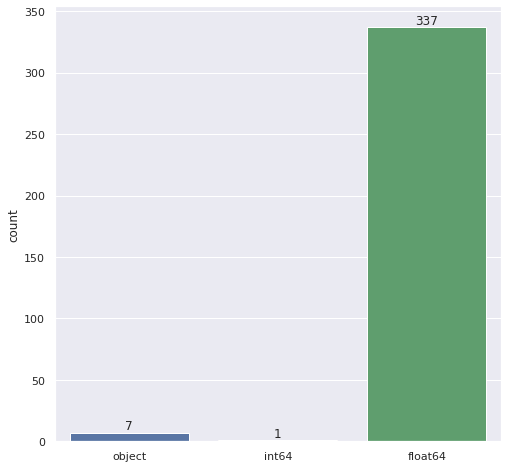

######################################################################################################################################################


In [11]:
plot_feature_types(peakTable)

## Balance in target feature

In [12]:
peakTable['Groups'].value_counts()

Incident    93
Non-case    93
Name: Groups, dtype: int64

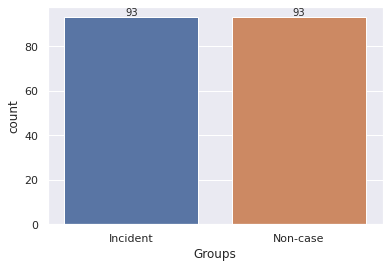

In [13]:
ax = sns.countplot(x='Groups', data=peakTable);
ax.bar_label(ax.containers[0]);

#### Ratio 1:1 between Healthy and Cancer patients --> consider the samples as a set of couples. We have a metadata file in which we have the paired samples, we will use later in the analysis.

## Missing value exploration

Function <code>plot_infos_missing_values</code> plots information about missing values in the peak table : total number of missing values, percent of missing values, plot heatmap, part of samples missing each compound, ...

######################################################################################################################################################
Total number of missing values : 9501
Percent of missing values : 15.16%



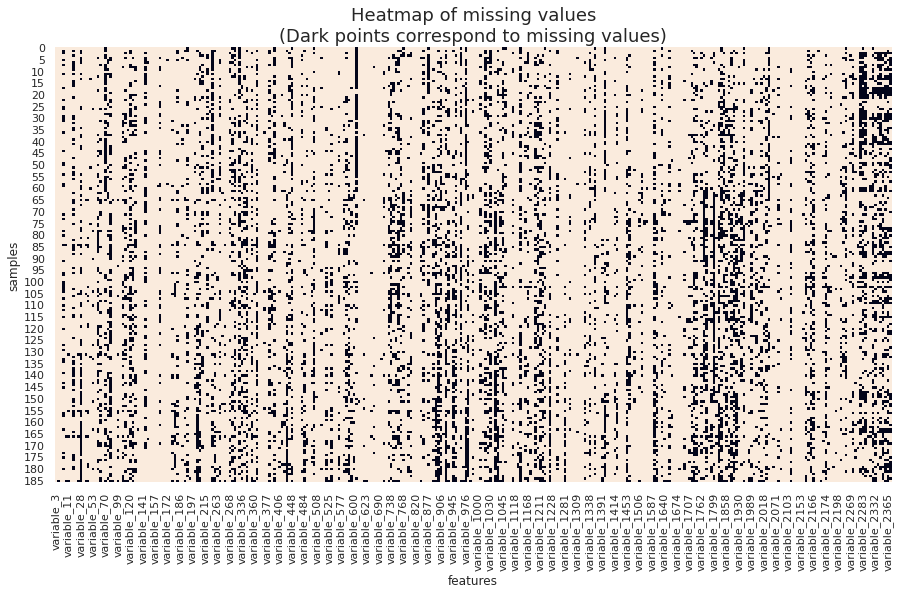

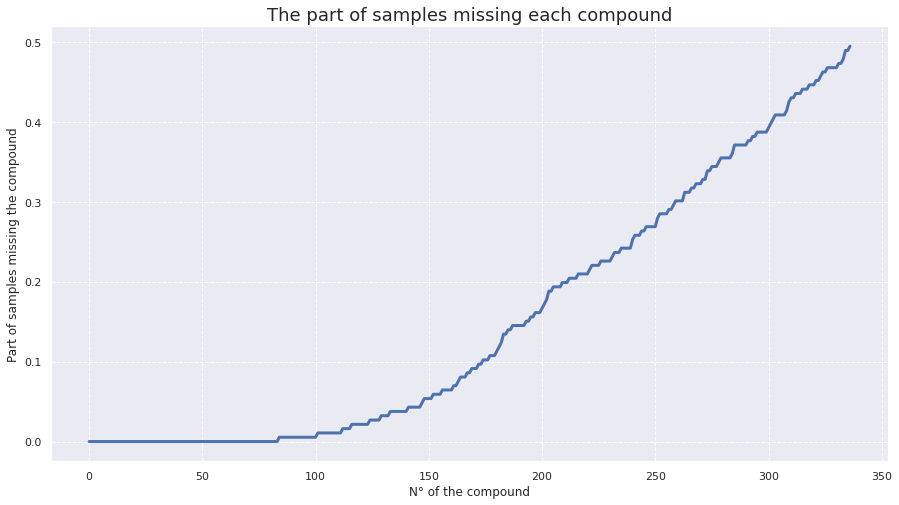



######################################################################################################################################################


In [14]:
plot_infos_missing_values(X)

### Also possible to run things separately

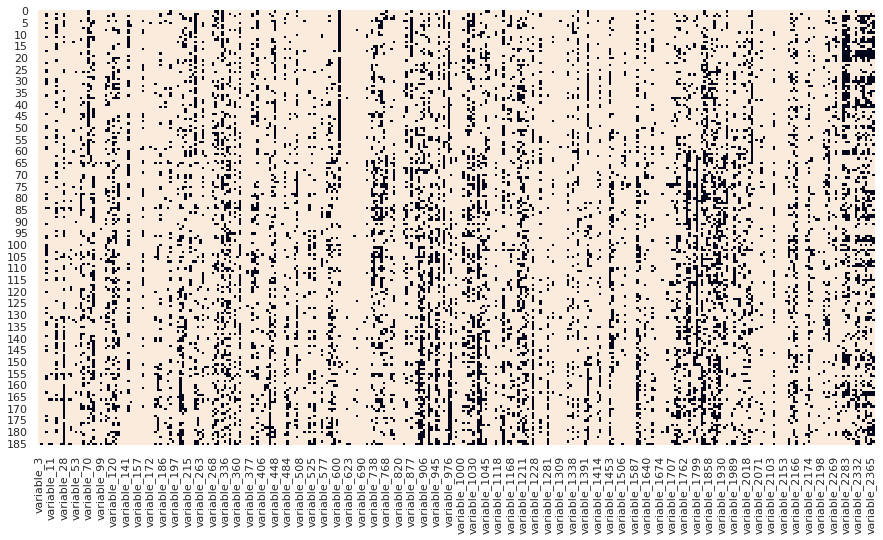

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(X.notna(), cbar=False);

In [16]:
X.isna()

variable_3  variable_5  variable_6  variable_8  variable_10  variable_11  \
0         False       False       False       False        False        False   
1         False       False       False        True        False        False   
2         False       False       False        True        False        False   
3         False       False       False       False        False        False   
4         False       False       False       False        False        False   
..          ...         ...         ...         ...          ...          ...   
181       False       False       False       False        False        False   
182       False       False       False       False        False        False   
183       False       False       False       False        False        False   
184       False       False       False       False        False        False   
185       False        True       False       False         True         True   

     variable_14  variable_22  variable_23  variable_25  ...  variable_2326  \
0          False        False        False        False  ...          False   
1          False         True        False        False  ...          False   
2          False        False        False        False  ...          False   
3          False         True        False        False  ...          False   
4          False        False        False        False  ...          False   
..           ...          ...          ...          ...  ...            ...   
181        False        False        False        False  ...           True   
182        False        False        False        False  ...          False   
183        False        False        False        False  ...          False   
184        False        False        False        False  ...          False   
185        False        False        False         True  ...          False   

     variable_2328  variable_2329  variable_2332  variable_2339  \
0            False           True          False          False   
1            False          False          False          False   
2            False          False           True           True   
3            False           True          False           True   
4            False          False           True           True   
..             ...            ...            ...            ...   
181          False           True          False          False   
182          False          False           True          False   
183           True          False          False          False   
184          False           True           True          False   
185          False           True           True          False   

     variable_2340  variable_2350  variable_2364  variable_2365  variable_2370  
0            False          False          False          False          False  
1            False          False          False           True          False  
2             True           True           True           True           True  
3             True          False           True          False          False  
4             True           True          False          False           True  
..             ...            ...            ...            ...            ...  
181          False          False           True           True           True  
182          False           True          False          False          False  
183          False           True          False           True          False  
184          False           True          False           True           True  
185          False          False           True           True          False  

[186 rows x 337 columns]

In [17]:
perc_mv = X.isna().sum() / X.shape[0]
perc_mv

variable_3       0.000000
variable_5       0.005376
variable_6       0.000000
variable_8       0.268817
variable_10      0.016129
                   ...   
variable_2340    0.370968
variable_2350    0.387097
variable_2364    0.354839
variable_2365    0.413978
variable_2370    0.360215
Length: 337, dtype: float64

In [18]:
perc_mv.max()

0.4946236559139785

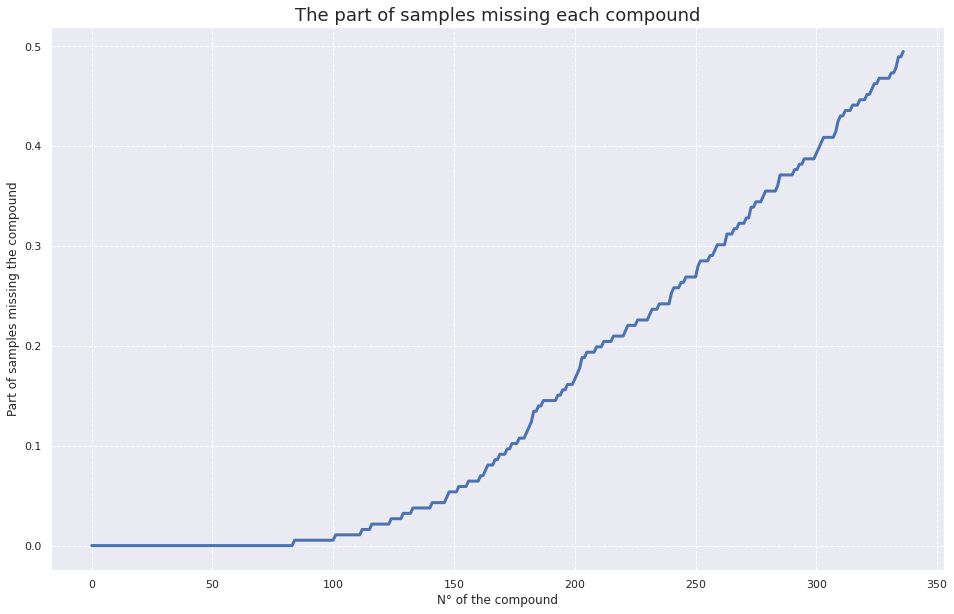

In [19]:
plt.figure(figsize=(16,10))
plt.plot(perc_mv.sort_values().values, color='b', linewidth=3)
plt.xlabel('N° of the compound', fontsize=12)
plt.ylabel('Part of samples missing the compound', fontsize=12)
plt.title('The part of samples missing each compound', fontsize=18)
plt.grid(linestyle='--', linewidth=1)
plt.show()

## Plot a first PCA (with peak table not preprocessed)

In [20]:
X_ = X.copy()

In [21]:
X_[X_.isna()] = 1

In [22]:
X_

variable_3  variable_5  variable_6  variable_8  variable_10  variable_11  \
0     19.761786   14.635833   22.185582   12.615143    15.580604    15.881437   
1     19.735279   15.193396   20.831414    1.000000    15.145423    14.034654   
2     19.116076   15.446714   22.152604    1.000000    14.628890    15.316772   
3     19.376875   15.460525   22.169389   12.720767    15.937169    15.967749   
4     19.555938   14.515536   22.150249   12.314019    14.950203    15.294906   
..          ...         ...         ...         ...          ...          ...   
181   19.664978   14.447858   20.808503   12.648327    14.806952    14.244917   
182   19.301954   14.839941   21.085175   12.510670    14.488147    15.163197   
183   19.170626   14.291711   21.381912   12.499558    14.434959    14.520558   
184   18.869505   14.440576   20.961485   12.312338    14.114074    13.776358   
185   18.954904    1.000000   20.005032   12.414258     1.000000     1.000000   

     variable_14  variable_22  variable_23  variable_25  ...  variable_2326  \
0      17.500899    12.792893    16.805604    16.805842  ...      13.194216   
1      17.953780     1.000000    15.907714    14.977232  ...      12.700734   
2      17.404715    12.786407    15.947176    16.238502  ...      12.618229   
3      15.836957     1.000000    16.371211    17.052231  ...      12.720631   
4      16.610171    12.214057    16.171763    16.107590  ...      12.564943   
..           ...          ...          ...          ...  ...            ...   
181    17.126579    12.080710    15.388376    15.352711  ...       1.000000   
182    16.816591    12.452644    16.474456    15.953391  ...      13.428278   
183    16.315887    12.808417    15.613263    15.522875  ...      13.213899   
184    16.110117    12.667428    16.021372    14.859646  ...      12.442173   
185    15.432975    12.047361    15.443640     1.000000  ...      12.806211   

     variable_2328  variable_2329  variable_2332  variable_2339  \
0        12.885181       1.000000      13.330208      12.052252   
1        12.742979      11.929552      13.464403      13.020365   
2        12.485436      11.709115       1.000000       1.000000   
3        12.564338       1.000000      13.397322       1.000000   
4        12.344968      12.127879       1.000000       1.000000   
..             ...            ...            ...            ...   
181      12.125251       1.000000      12.686218      12.349299   
182      12.629126      12.360380       1.000000      12.909283   
183       1.000000      11.870228      12.680070      12.846355   
184      12.291946       1.000000       1.000000      12.477753   
185      12.507333       1.000000       1.000000      13.225899   

     variable_2340  variable_2350  variable_2364  variable_2365  variable_2370  
0        12.568647      13.192848      12.248590      12.114328      12.355017  
1        12.928643      13.697314      12.604052       1.000000      12.208084  
2         1.000000       1.000000       1.000000       1.000000       1.000000  
3         1.000000      13.086805       1.000000      11.605353      12.319119  
4         1.000000       1.000000      12.349830      11.926237       1.000000  
..             ...            ...            ...            ...            ...  
181      11.505004      13.189121       1.000000       1.000000       1.000000  
182      12.642143       1.000000      12.708850      12.462751      12.635066  
183      13.243400       1.000000      12.199647       1.000000      12.258149  
184      11.789382       1.000000      11.628154       1.000000       1.000000  
185      12.978890      11.596877       1.000000       1.000000      12.158923  

[186 rows x 337 columns]

In [23]:
cb.plot.pca(X_, pcx=1, pcy=2, group_label=peakTable['Groups'])

Loading BokehJS ...

In [24]:
cb.plot.pca(X_, pcx=1, pcy=3, group_label=peakTable['Groups'])

Loading BokehJS ...

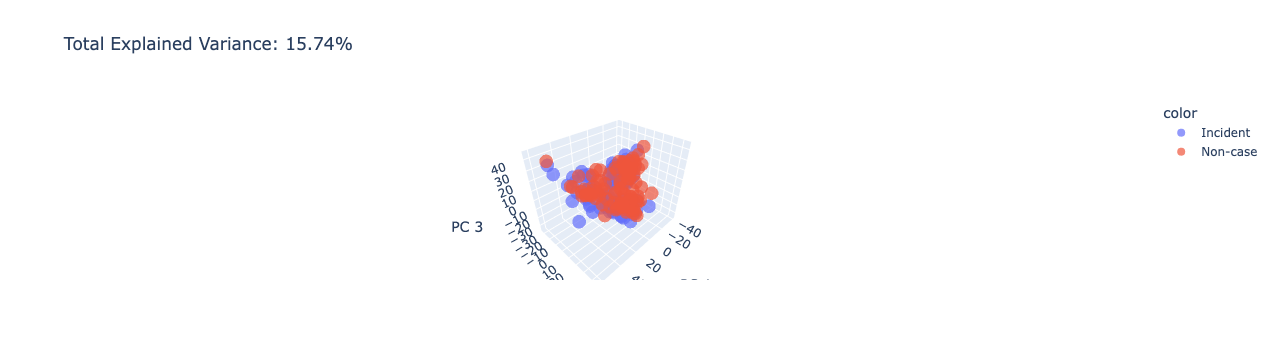

In [27]:
PCA_3D(X_, peakTable, 'Groups')

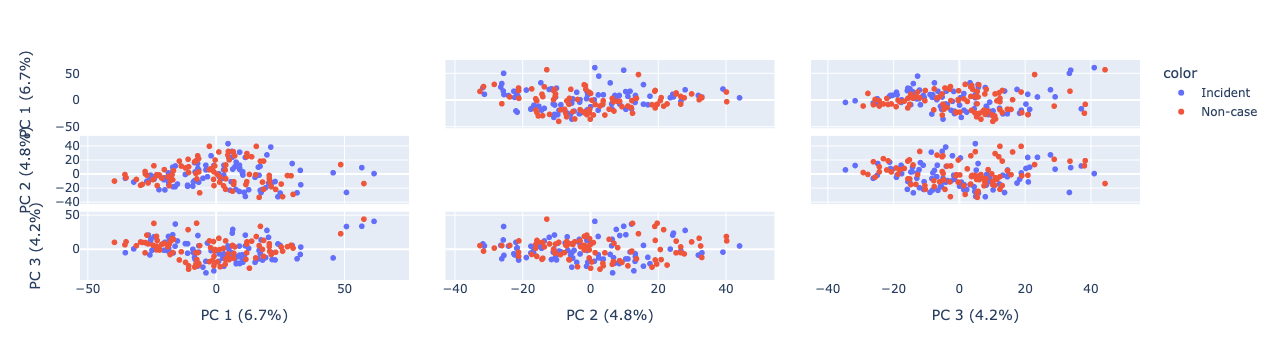

In [28]:
PCA_paired(X_, peakTable, 'Groups')

# Content analysis

## Target visualisation

In [29]:
peakTable['Groups'].value_counts()

Incident    93
Non-case    93
Name: Groups, dtype: int64

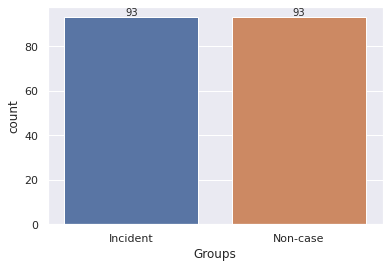

In [30]:
ax = sns.countplot(x='Groups', data=peakTable);
ax.bar_label(ax.containers[0]);

Ratio 1:1, each patient has a matched control

## Metadata visualisation

In [31]:
peakTable.head()

SampleID    Groups  MatchCaseset   TypTumo CaseHCCWide          EPICID  \
0  LivCan_153  Incident            82       HCC         Yes  41____41041872   
1  LivCan_154  Non-case            82       NaN          No  41____41046868   
2  LivCan_267  Incident           427       HCC         Yes  41____41074588   
3  LivCan_268  Non-case           427       NaN          No  41____41089214   
4  LivCan_299  Incident           376  HCC_Wide         Yes  21____21103888   

        EPICBioID      AliquotID  variable_3  variable_5  ...  variable_2326  \
0  41____41041872  41041872-s2#C   19.761786   14.635833  ...      13.194216   
1  41____41046868  41046868-s2#C   19.735279   15.193396  ...      12.700734   
2  41____41074588  41074588-s1#B   19.116076   15.446714  ...      12.618229   
3  41____41089214  41089214-s1#B   19.376875   15.460525  ...      12.720631   
4  21____21103888  21103888-s1#B   19.555938   14.515536  ...      12.564943   

   variable_2328  variable_2329  variable_2332  variable_2339  variable_2340  \
0      12.885181            NaN      13.330208      12.052252      12.568647   
1      12.742979      11.929552      13.464403      13.020365      12.928643   
2      12.485436      11.709115            NaN            NaN            NaN   
3      12.564338            NaN      13.397322            NaN            NaN   
4      12.344968      12.127879            NaN            NaN            NaN   

   variable_2350  variable_2364  variable_2365  variable_2370  
0      13.192848      12.248590      12.114328      12.355017  
1      13.697314      12.604052            NaN      12.208084  
2            NaN            NaN            NaN            NaN  
3      13.086805            NaN      11.605353      12.319119  
4            NaN      12.349830      11.926237            NaN  

[5 rows x 345 columns]

### Number of unique values for each of feature in metadata

In [32]:
peakTable.dtypes[peakTable.dtypes == 'object']

SampleID       object
Groups         object
TypTumo        object
CaseHCCWide    object
EPICID         object
EPICBioID      object
AliquotID      object
dtype: object

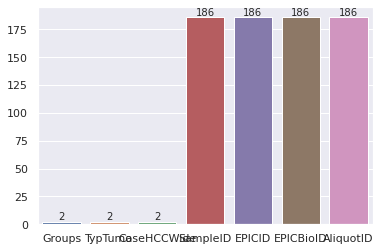

In [33]:
unique_values = peakTable[peakTable.dtypes[peakTable.dtypes == 'object'].index].nunique().sort_values()

ax = sns.barplot(x=unique_values.index, y=unique_values.values);
ax.bar_label(ax.containers[0]);

### TypTumo : Type of tumor, i.e. HCC or HCC Wide

In [34]:
peakTable['TypTumo'].value_counts(dropna=False)

NaN         93
HCC         80
HCC_Wide    13
Name: TypTumo, dtype: int64

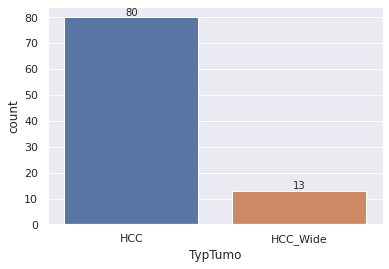

In [35]:
ax = sns.countplot(x='TypTumo', data=peakTable);
ax.bar_label(ax.containers[0]);

### MatchCaseset : ID for paired samples

In [36]:
all(peakTable['MatchCaseset'].value_counts() == 2)

True

All samples are indeed in paires

## Feature visualisation

The following visualisations show the distributions of the first 10 features of the peak table.

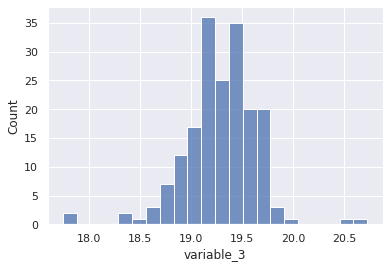

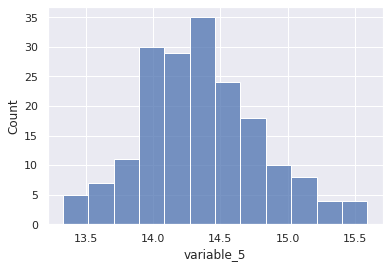

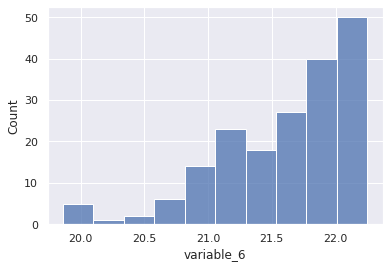

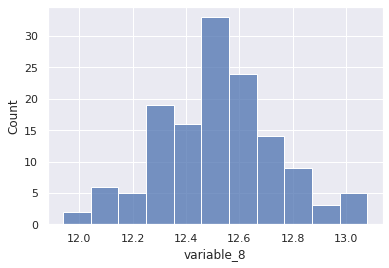

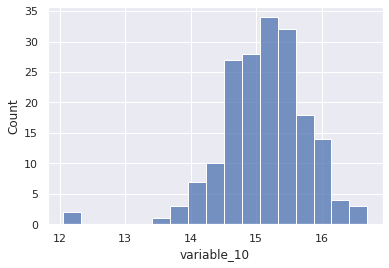

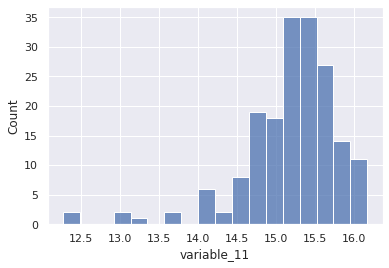

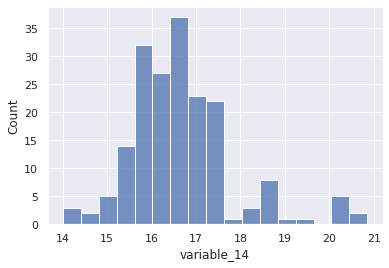

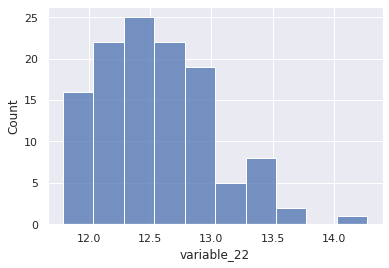

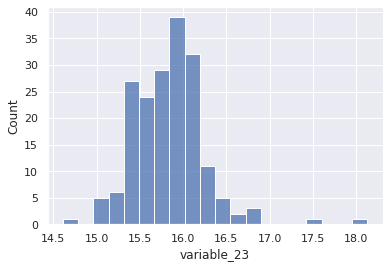

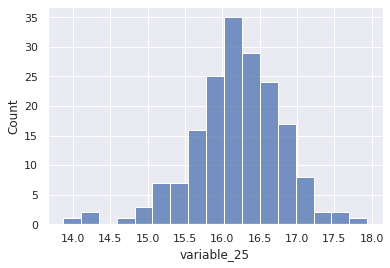

In [37]:
for col in X.columns[0:10]:
    
    plt.figure()
    sns.histplot(X[col])

Some of the compounds seem to be normally distributed, some other present extreme values. We can maybe think that these non-normal distribution show the difference between Healthy and Patient samples ?

### Feature visualisation, separated according to group

------------------------------------------------------------------------------------------------------------------------


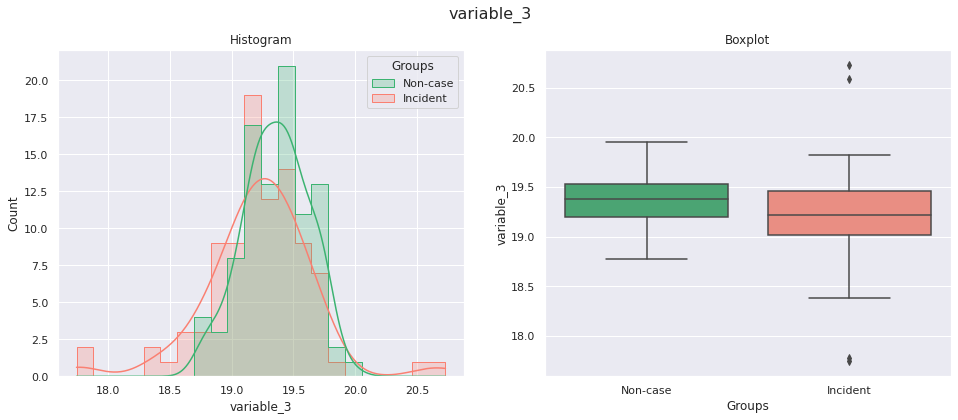

------------------------------------------------------------------------------------------------------------------------


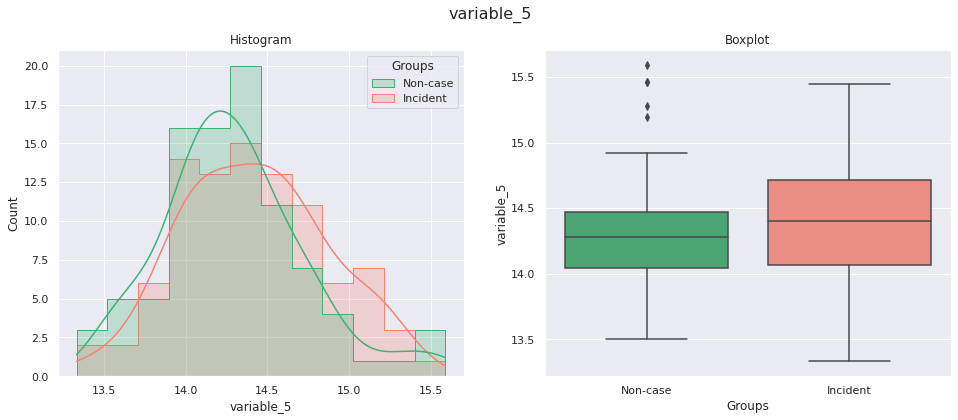

------------------------------------------------------------------------------------------------------------------------


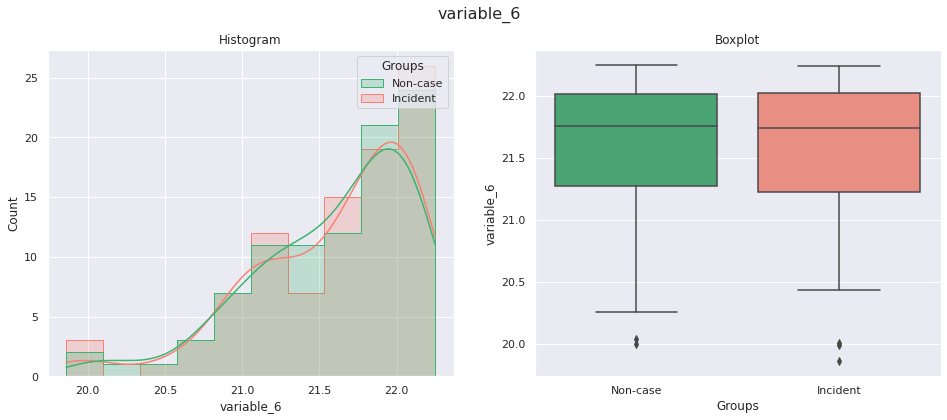

------------------------------------------------------------------------------------------------------------------------


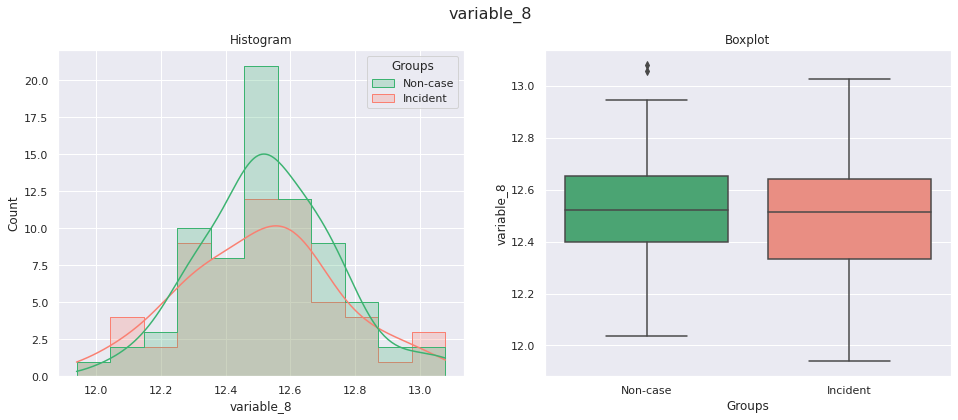

------------------------------------------------------------------------------------------------------------------------


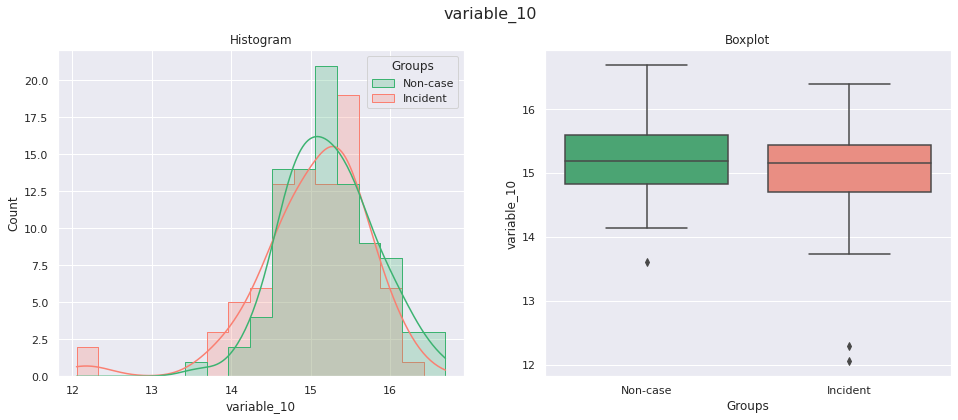

------------------------------------------------------------------------------------------------------------------------


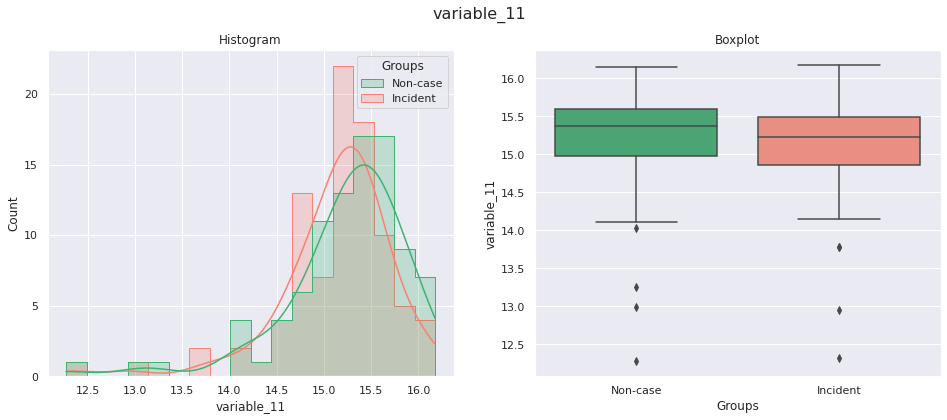

------------------------------------------------------------------------------------------------------------------------


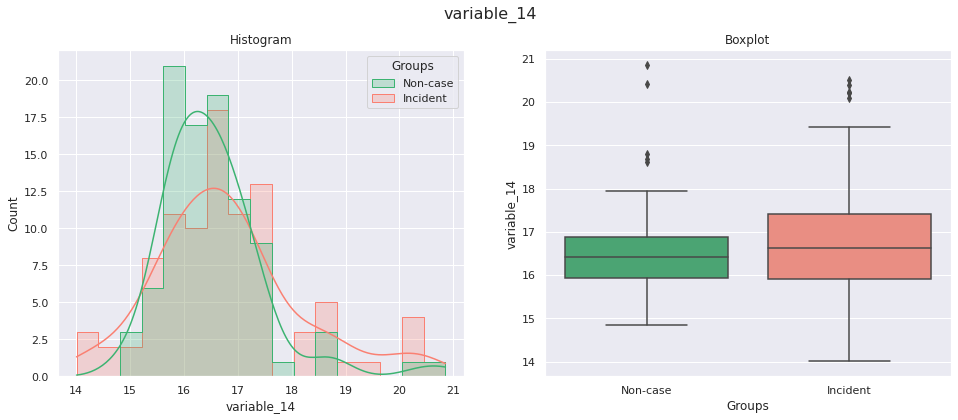

------------------------------------------------------------------------------------------------------------------------


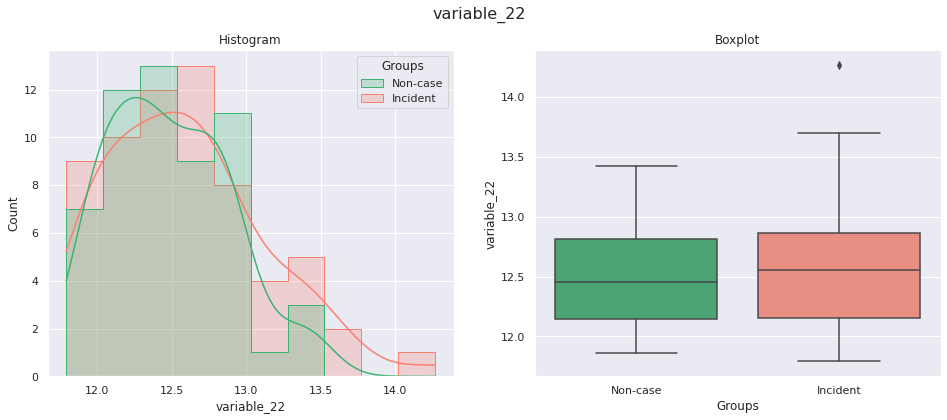

------------------------------------------------------------------------------------------------------------------------


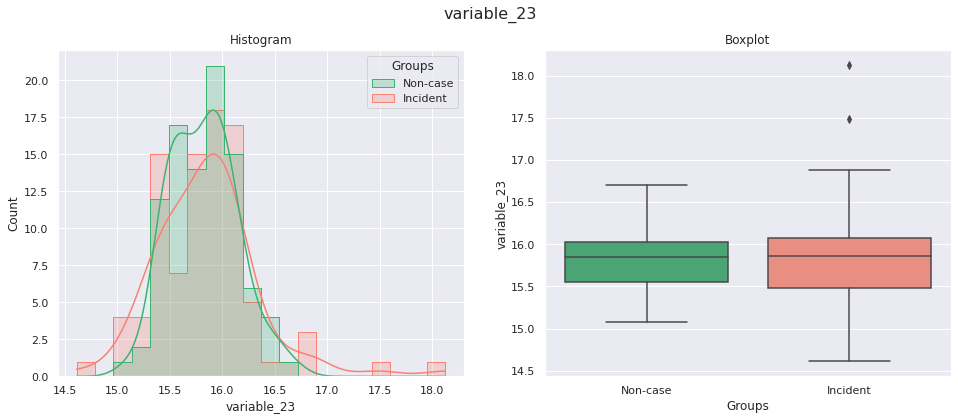

------------------------------------------------------------------------------------------------------------------------


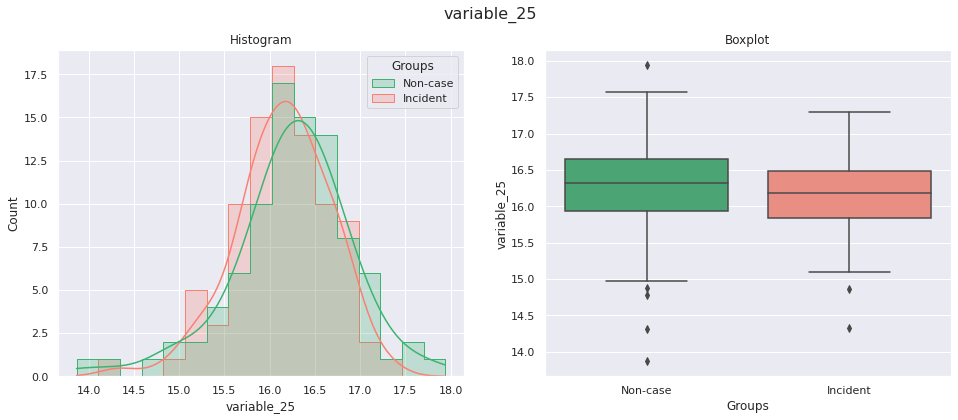

In [38]:
palette = {'Incident': 'salmon', 'Non-case': 'mediumseagreen'}

for col in [col for col in peakTable.columns if 'variable' in col][:10]:
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=peakTable, x=peakTable[col], hue='Groups', hue_order=['Non-case', 'Incident'], kde=True, element='step', palette=palette)
    plt.title('Histogram')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Groups', y=col, data=peakTable, order=['Non-case', 'Incident'], palette=palette)
    plt.title('Boxplot')
    
    plt.suptitle(col, fontsize=16)
    
    print(120 * '-')
    
    plt.show()

On this visualisations, it is really difficult to see a clear difference between the Incident and Non-case groups.

### Feature visualisation, separated according to group and tumor type

In [39]:
peakTable_copy = peakTable.copy()
peakTable_copy['TypTumo'] = peakTable_copy['TypTumo'].fillna('Non-case')
peakTable_copy.head()

SampleID    Groups  MatchCaseset   TypTumo CaseHCCWide          EPICID  \
0  LivCan_153  Incident            82       HCC         Yes  41____41041872   
1  LivCan_154  Non-case            82  Non-case          No  41____41046868   
2  LivCan_267  Incident           427       HCC         Yes  41____41074588   
3  LivCan_268  Non-case           427  Non-case          No  41____41089214   
4  LivCan_299  Incident           376  HCC_Wide         Yes  21____21103888   

        EPICBioID      AliquotID  variable_3  variable_5  ...  variable_2326  \
0  41____41041872  41041872-s2#C   19.761786   14.635833  ...      13.194216   
1  41____41046868  41046868-s2#C   19.735279   15.193396  ...      12.700734   
2  41____41074588  41074588-s1#B   19.116076   15.446714  ...      12.618229   
3  41____41089214  41089214-s1#B   19.376875   15.460525  ...      12.720631   
4  21____21103888  21103888-s1#B   19.555938   14.515536  ...      12.564943   

   variable_2328  variable_2329  variable_2332  variable_2339  variable_2340  \
0      12.885181            NaN      13.330208      12.052252      12.568647   
1      12.742979      11.929552      13.464403      13.020365      12.928643   
2      12.485436      11.709115            NaN            NaN            NaN   
3      12.564338            NaN      13.397322            NaN            NaN   
4      12.344968      12.127879            NaN            NaN            NaN   

   variable_2350  variable_2364  variable_2365  variable_2370  
0      13.192848      12.248590      12.114328      12.355017  
1      13.697314      12.604052            NaN      12.208084  
2            NaN            NaN            NaN            NaN  
3      13.086805            NaN      11.605353      12.319119  
4            NaN      12.349830      11.926237            NaN  

[5 rows x 345 columns]

------------------------------------------------------------------------------------------------------------------------


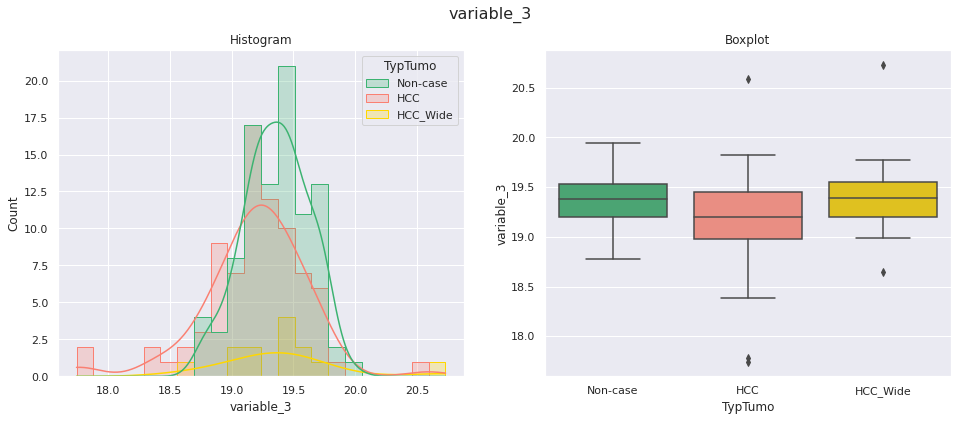

------------------------------------------------------------------------------------------------------------------------


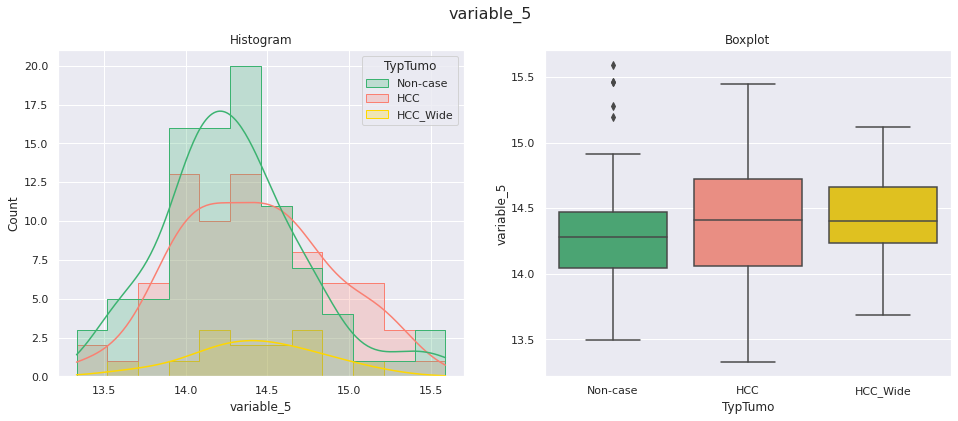

------------------------------------------------------------------------------------------------------------------------


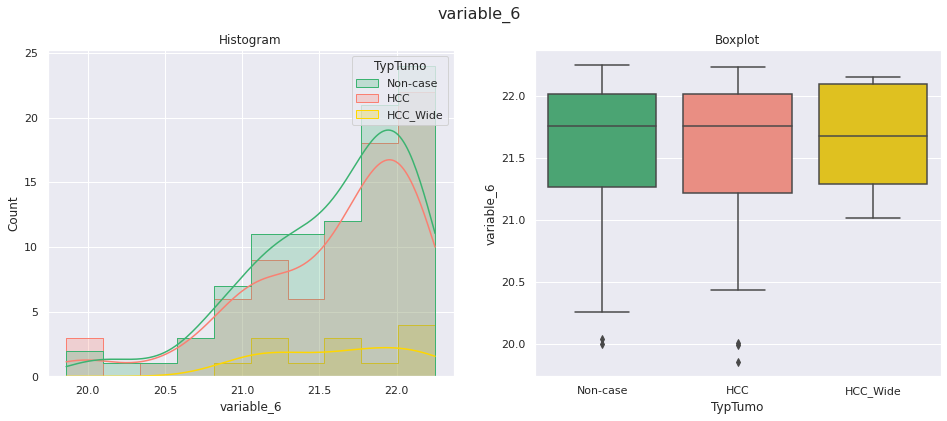

------------------------------------------------------------------------------------------------------------------------


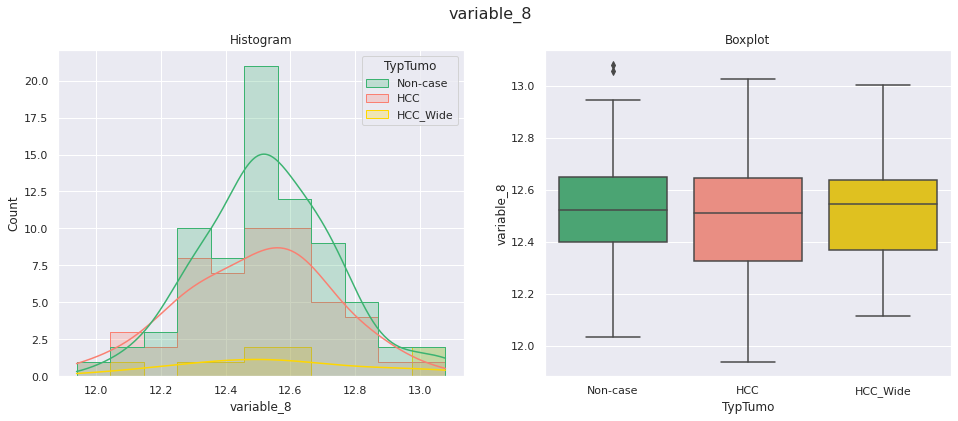

------------------------------------------------------------------------------------------------------------------------


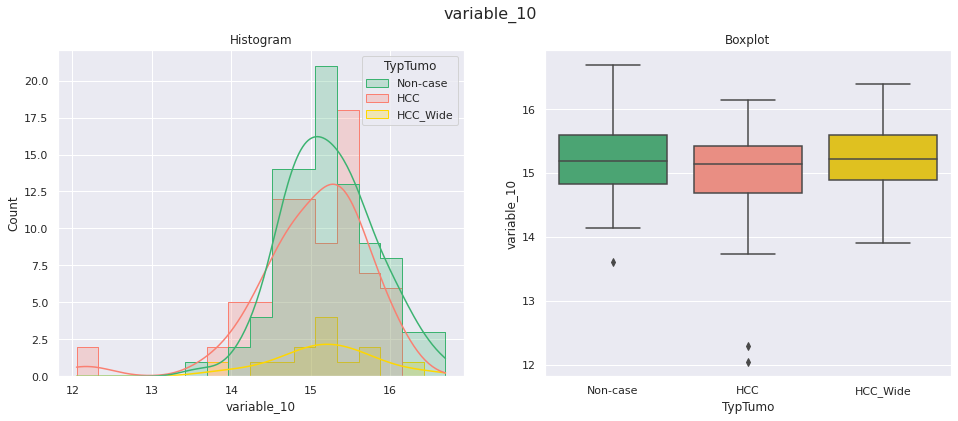

------------------------------------------------------------------------------------------------------------------------


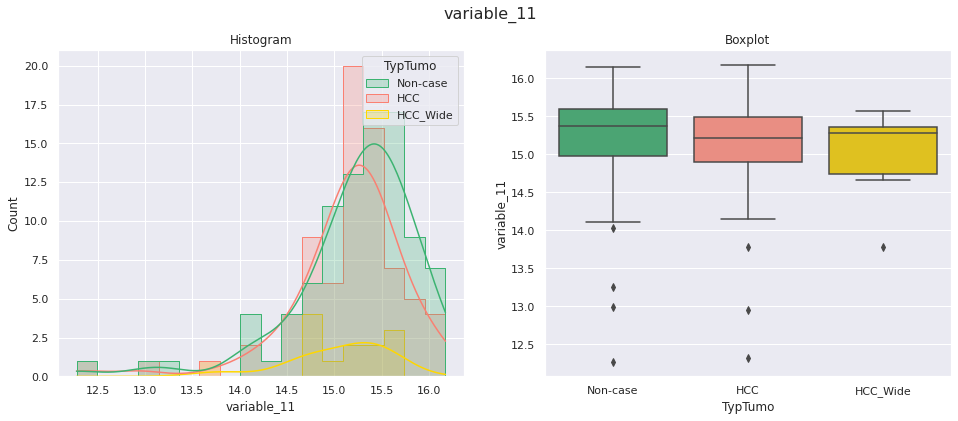

------------------------------------------------------------------------------------------------------------------------


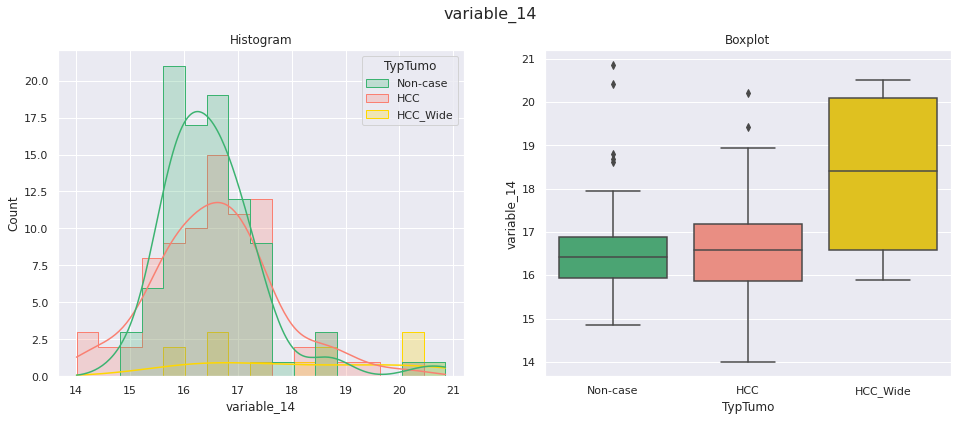

------------------------------------------------------------------------------------------------------------------------


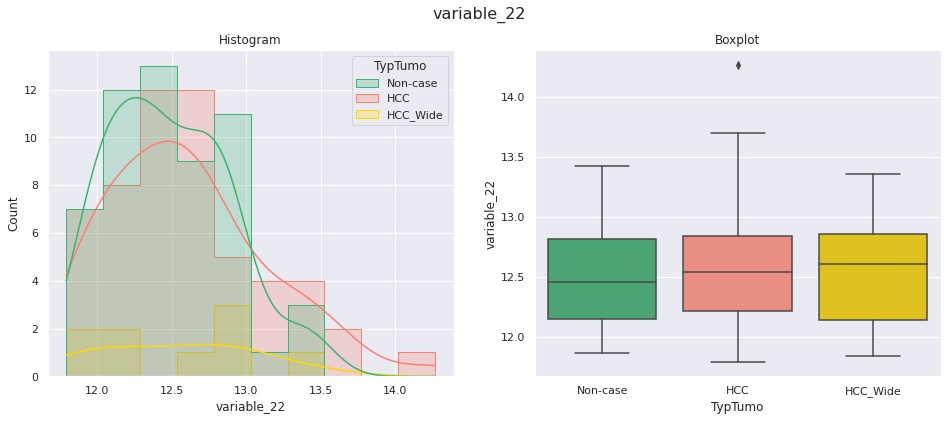

------------------------------------------------------------------------------------------------------------------------


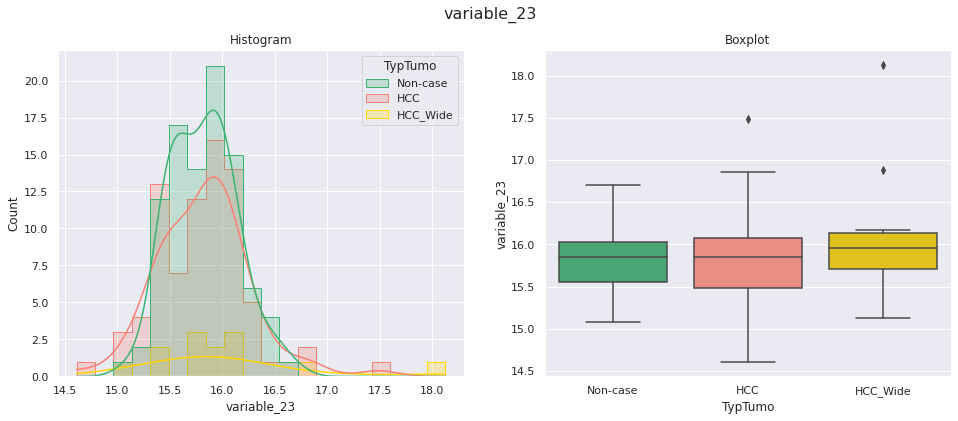

------------------------------------------------------------------------------------------------------------------------


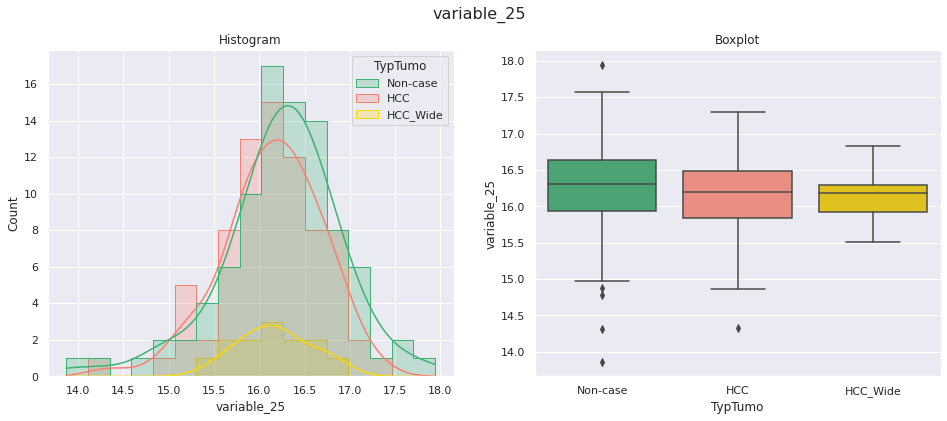

In [40]:
palette = {'Non-case': 'mediumseagreen', 'HCC': 'salmon', 'HCC_Wide': 'gold'}

for col in [col for col in peakTable_copy.columns if 'variable' in col][:10]:
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=peakTable_copy, x=peakTable_copy[col], hue='TypTumo', hue_order=['Non-case', 'HCC', 'HCC_Wide'], kde=True, element='step', palette=palette)
    plt.title('Histogram')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='TypTumo', y=col, data=peakTable_copy, order=['Non-case', 'HCC', 'HCC_Wide'], palette=palette)
    plt.title('Boxplot')
    
    plt.suptitle(col, fontsize=16)
    
    print(120 * '-')
    
    plt.show()

### Visualise feature correlations

On the following heatmap, we can see the correlation table between all the features.

We can use different methods in the function <code>corr()</code> :
- <code>pearson</code> : measures the linear relationship between two variables
- <code>spearman</code> : measures the statistical dependence between the rankings of two variables i.e. described using a monotonic function
- <code>kendall</code> : also measures a rank correlation

Spearman and Kendall methods are more robust because they don't make the assumption that the data follows a normal distribution.

------------------------------------------------------------------------------------------------------------------------------------------------------


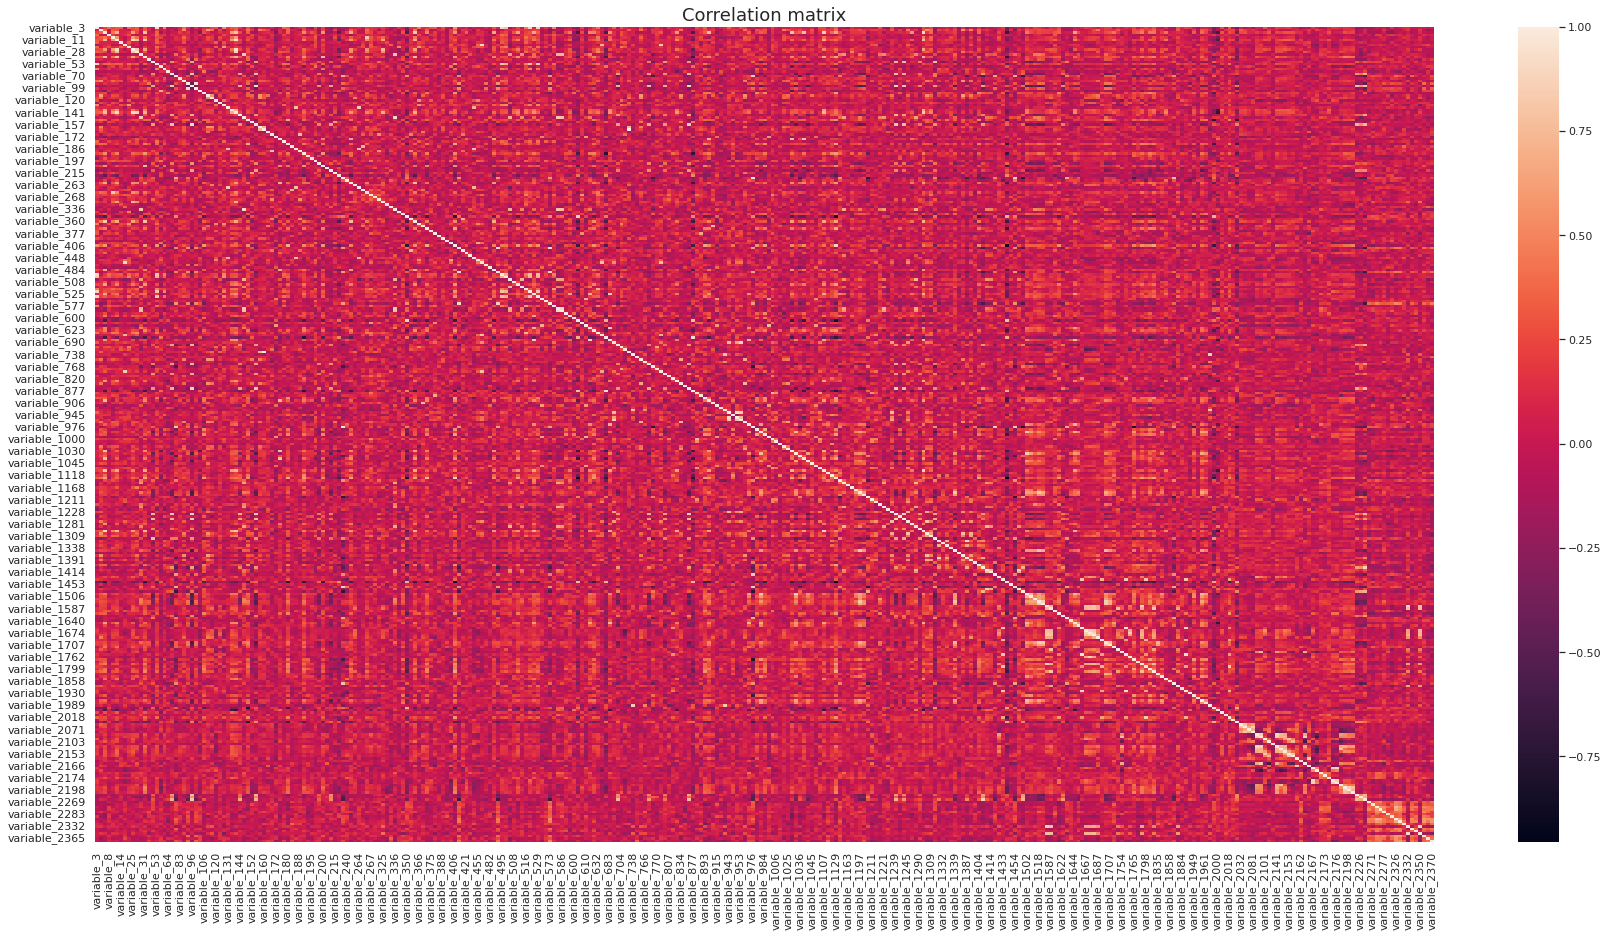

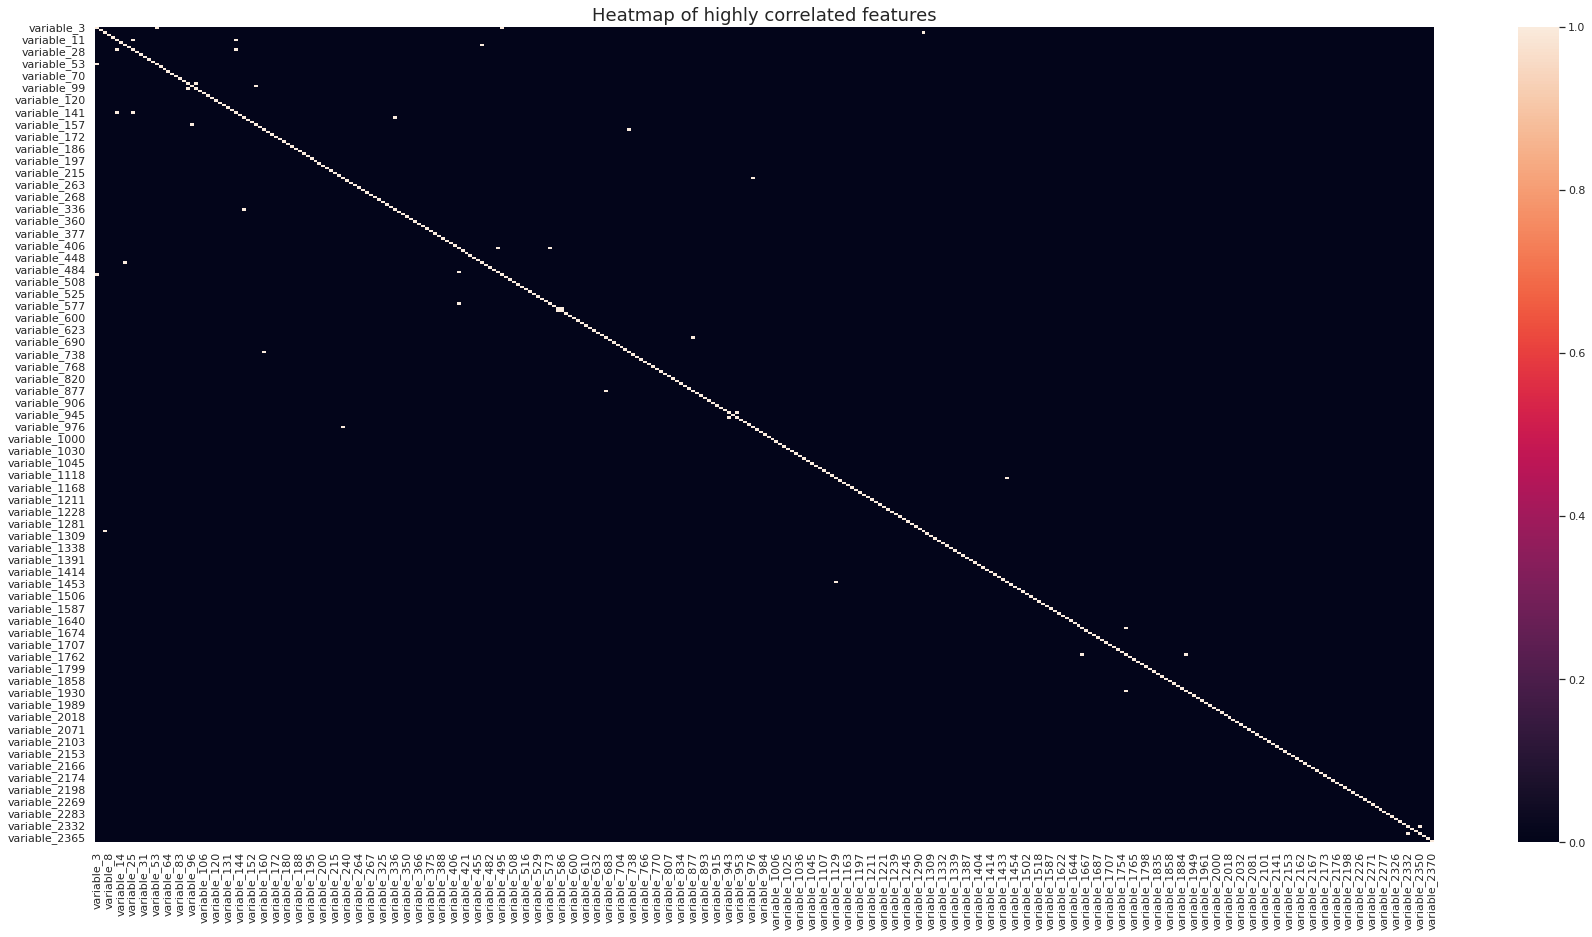



------------------------------------------------------------------------------------------------------------------------------------------------------


In [41]:
plot_correlation_matrix(X, threshold=0.9)

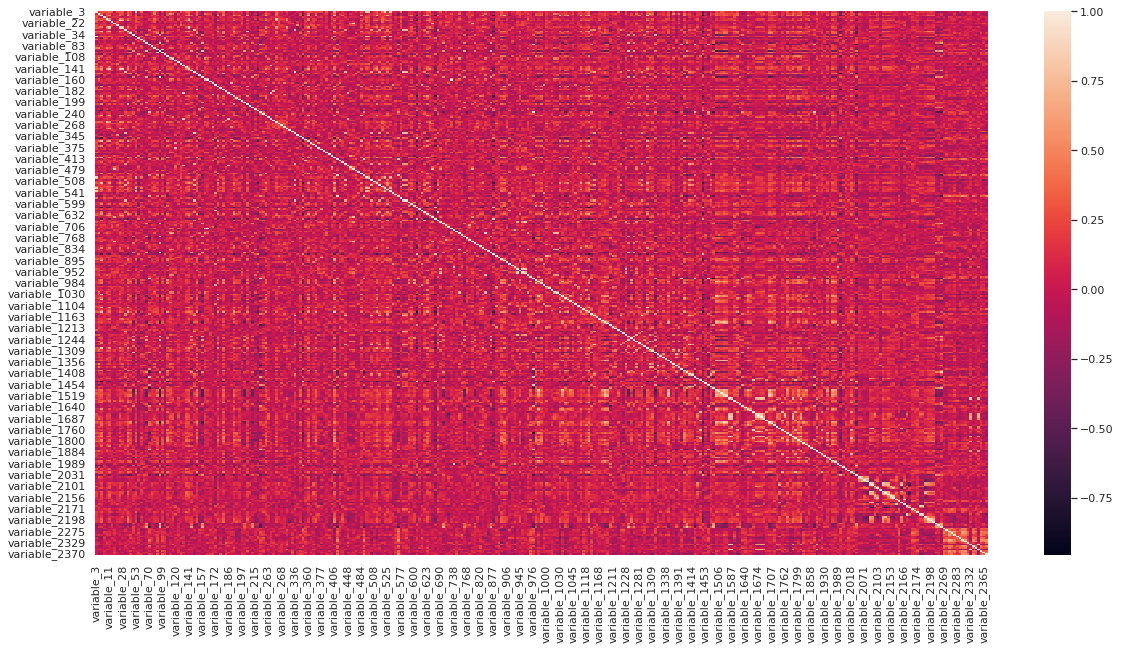

In [42]:
plt.figure(figsize=(20,10))
sns.heatmap(X.corr(method='spearman'));

On this heatmap, the light dots are the features pairs which have a strong positive or negative correlation

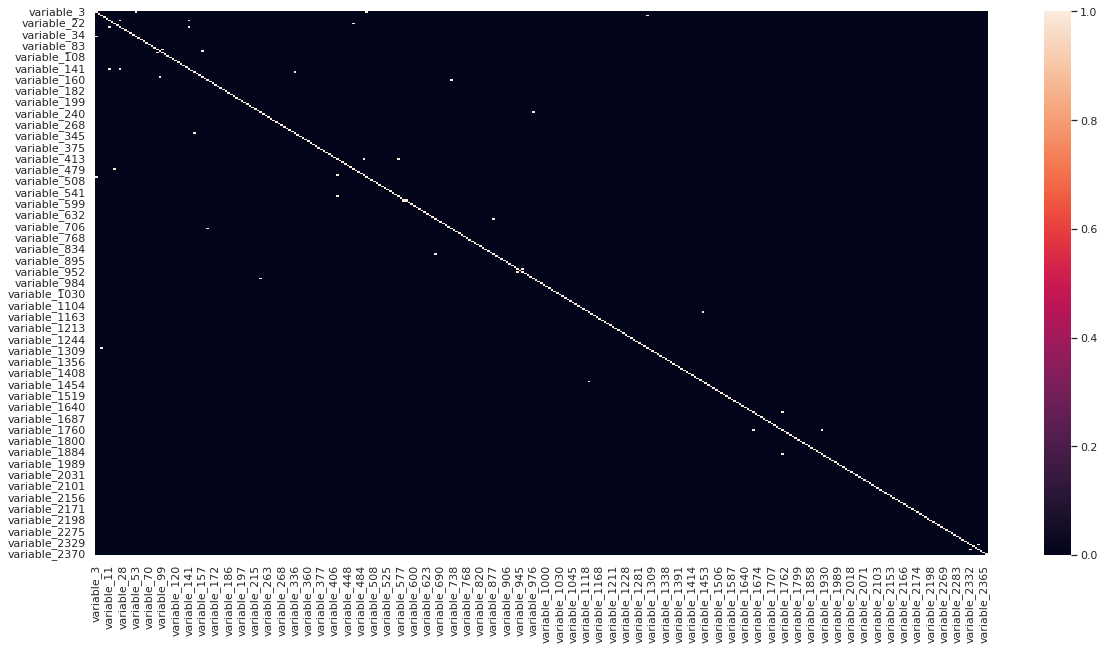

In [43]:
plt.figure(figsize=(20,10))
sns.heatmap((X.corr(method='pearson') > 0.9) | (X.corr(method='pearson') < -0.9));

On the previous notebook, for each compound, we removed the features with a too strong correlation. This means that the pairs of features above with a strong correlation should not belong to the same compound.

### Test of normality with Shapiro-Wilk test : _scipy.stats.shapiro_

For each variable in the peak table, we want to know if it is normally distributed, to apply either parametric ou non-parametric tests in the follow-up.

In [44]:
shapiro_results_X = shapiro_test_df(X)
shapiro_results_X

shapiro_score        pvalue
Compounds                                 
variable_3          0.937199  3.106757e-07
variable_5          0.986075  6.421676e-02
variable_6          0.897900  5.353651e-10
variable_8          0.993316  7.750993e-01
variable_10         0.947433  2.804746e-06
...                      ...           ...
variable_2340       0.981445  1.058098e-01
variable_2350       0.992897  8.281244e-01
variable_2364       0.987211  3.209825e-01
variable_2365       0.988089  4.508107e-01
variable_2370       0.990424  5.788468e-01

[337 rows x 2 columns]

In [45]:
alpha = 0.05
print(f'With alpha={alpha}, {len(shapiro_results_X[shapiro_results_X["pvalue"] < alpha]) / len(shapiro_results_X) * 100:.2f}% of features are normally distributed')

With alpha=0.05, 69.73% of features are normally distributed


## Paired tests between two groups (Incident vs Non-case) :
### $\rightarrow$ paired t-test (parametric) or Wilcoxon (non-parametric)

<center>
<img src="../img/paired_tests.png" alt="Schema for statistical analysis of variable distributions" width="800"/>
</center>


In [46]:
test_result = paired_test_t_or_Wilcoxon(peakTable, X, alpha_shapiro=0.05)
test_result

Time to compute : 00:00:35


NormallyDistributed    TestApplied    statistic    pvalue
Variable                                                               
variable_3                  False       Wilcoxon  1270.000000  0.000452
variable_5                   True  Paired t-test     2.644733  0.009630
variable_6                  False       Wilcoxon  2082.000000  0.691685
variable_8                   True  Paired t-test    -1.091111  0.280671
variable_10                  True  Paired t-test    -1.994325  0.049177
...                           ...            ...          ...       ...
variable_2340                True  Paired t-test    -0.059732  0.952666
variable_2350                True  Paired t-test    -0.091754  0.927432
variable_2364                True  Paired t-test     0.494443  0.623698
variable_2365                True  Paired t-test     1.208598  0.235406
variable_2370                True  Paired t-test    -0.157771  0.875473

[337 rows x 4 columns]

In [47]:
alpha = 0.05
print(f'With alpha={alpha}, {len(test_result[test_result["pvalue"] < alpha]) / len(test_result) * 100 :.1f}% \
of features are significantly differentially distributed between Incident and Non-case groups.')

With alpha=0.05, 19.3% of features are significantly differentially distributed between Incident and Non-case groups.


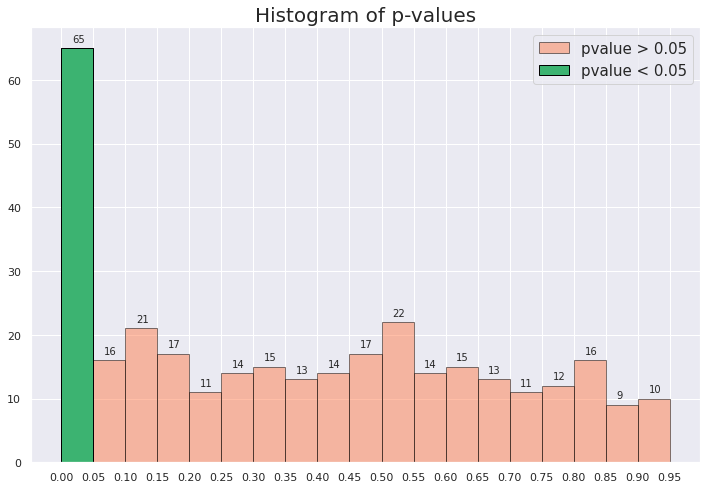

In [48]:
plot_hist_pvalue(test_result, 0.05)

### Multiple testing correction

"Statistical hypothesis testing is based on rejecting the null hypothesis if the likelihood of the observed data under the null hypotheses is low. If multiple hypotheses are tested, the chance of observing a rare event increases, and therefore, the likelihood of incorrectly rejecting a null hypothesis (i.e., making a Type I error) increases." (cf [link](https://en.wikipedia.org/wiki/Bonferroni_correction))

"Multiple testing correction refers to making statistical tests more stringent in order to counteract the problem of multiple testing" (cf. [link](https://en.wikipedia.org/wiki/Multiple_comparisons_problem))

## Resources :

- http://www.biostathandbook.com/multiplecomparisons.html
- https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method#Adjusted_p-values
- https://towardsdatascience.com/an-overview-of-methods-to-address-the-multiple-comparison-problem-310427b3ba92
- https://www.nonlinear.com/support/progenesis/comet/faq/v2.0/pq-values.aspx

## Test with Bonferroni correction

In [49]:
test_result2 = pvalue_correction(df = test_result, correction = 'Bonferroni', alpha = 0.05)
test_result2

NormallyDistributed    TestApplied    statistic    pvalue  \
Variable                                                                  
variable_3                  False       Wilcoxon  1270.000000  0.000452   
variable_5                   True  Paired t-test     2.644733  0.009630   
variable_6                  False       Wilcoxon  2082.000000  0.691685   
variable_8                   True  Paired t-test    -1.091111  0.280671   
variable_10                  True  Paired t-test    -1.994325  0.049177   
...                           ...            ...          ...       ...   
variable_2340                True  Paired t-test    -0.059732  0.952666   
variable_2350                True  Paired t-test    -0.091754  0.927432   
variable_2364                True  Paired t-test     0.494443  0.623698   
variable_2365                True  Paired t-test     1.208598  0.235406   
variable_2370                True  Paired t-test    -0.157771  0.875473   

               alpha  H0rejected  alphaCorrected  H0rejectedCorrected  
Variable                                                               
variable_3      0.05        True        0.000148                False  
variable_5      0.05        True        0.000148                False  
variable_6      0.05       False        0.000148                False  
variable_8      0.05       False        0.000148                False  
variable_10     0.05        True        0.000148                False  
...              ...         ...             ...                  ...  
variable_2340   0.05       False        0.000148                False  
variable_2350   0.05       False        0.000148                False  
variable_2364   0.05       False        0.000148                False  
variable_2365   0.05       False        0.000148                False  
variable_2370   0.05       False        0.000148                False  

[337 rows x 8 columns]

In [50]:
print(f'Before correction, {sum(test_result2["H0rejected"]) / test_result2.shape[0] * 100 :.1f}% \
of features are significantly differentially distributed ({sum(test_result2["H0rejected"])} features).')
print(f'After correction, {sum(test_result2["H0rejectedCorrected"]) / test_result2.shape[0] * 100 :.1f}% \
of features are still significantly differentially distributed ({sum(test_result2["H0rejectedCorrected"])} features).')
print(f'We will explore later with an other function to which biological compounds these \
{sum(test_result2["H0rejectedCorrected"])} features correspond !')
print()
print(f'{test_result2[(test_result2["H0rejected"] == True) & (test_result2["H0rejectedCorrected"] == False)].shape[0]} \
features were significant before but not after the correction, for example the following five features :')

Before correction, 19.3% of features are significantly differentially distributed (65 features).
After correction, 2.7% of features are still significantly differentially distributed (9 features).
We will explore later with an other function to which biological compounds these 9 features correspond !

56 features were significant before but not after the correction, for example the following five features :


In [51]:
test_result2[(test_result2['H0rejected'] == True) & (test_result2['H0rejectedCorrected'] == False)].head()

NormallyDistributed    TestApplied    statistic    pvalue  alpha  \
Variable                                                                       
variable_3                False       Wilcoxon  1270.000000  0.000452   0.05   
variable_5                 True  Paired t-test     2.644733  0.009630   0.05   
variable_10                True  Paired t-test    -1.994325  0.049177   0.05   
variable_31                True  Paired t-test    -2.132354  0.035863   0.05   
variable_56                True  Paired t-test     2.588981  0.011189   0.05   

             H0rejected  alphaCorrected  H0rejectedCorrected  
Variable                                                      
variable_3         True        0.000148                False  
variable_5         True        0.000148                False  
variable_10        True        0.000148                False  
variable_31        True        0.000148                False  
variable_56        True        0.000148                False

Below we can observe the pvalue for each feature, zooming on features which have a pvalue lower than *alpha* and *alphaCorrected*.

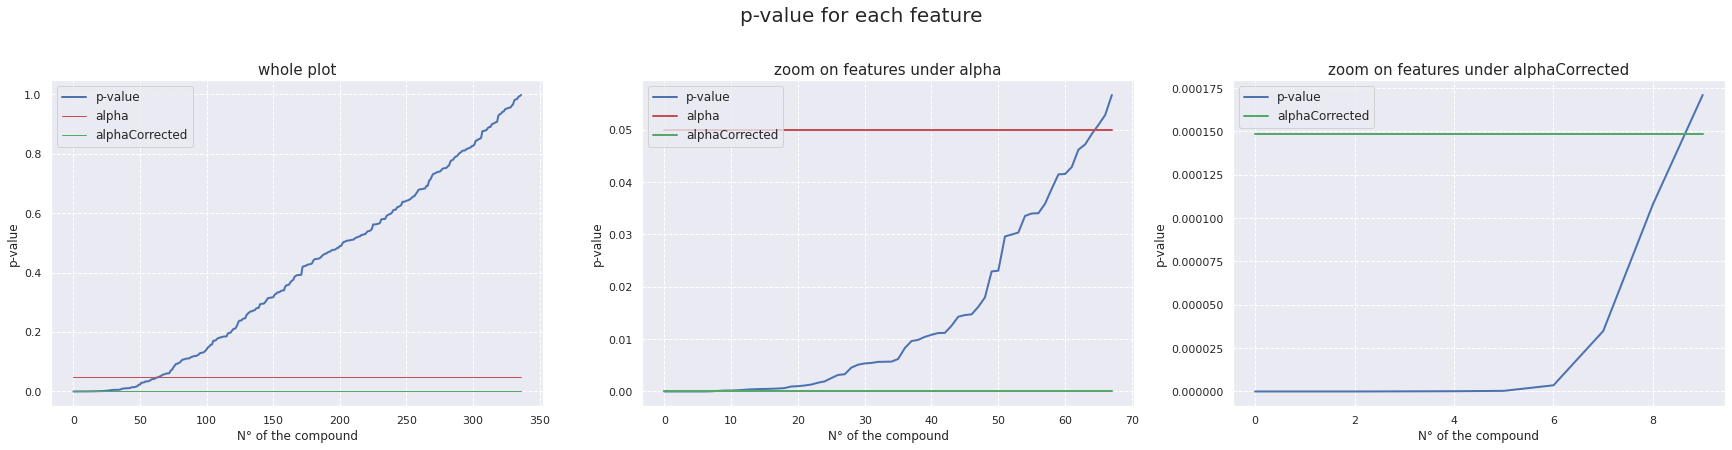

In [52]:
plot_pvalue(test_result2)

Here is the barplot of the number of features with are significantly differentially distributed (True) or not (False).

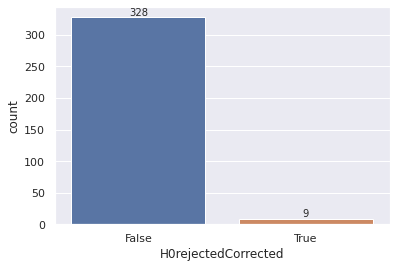

In [53]:
ax = sns.countplot(x='H0rejectedCorrected', data=test_result2);
ax.bar_label(ax.containers[0]);

Below are the features which have a significant difference between Incident and Non-case groups.

In [54]:
test_result2[test_result2['H0rejectedCorrected'] == True]

NormallyDistributed    TestApplied    statistic        pvalue  \
Variable                                                                      
variable_455                 True  Paired t-test     4.937208  3.572263e-06   
variable_1587                True  Paired t-test    -5.853069  7.357586e-08   
variable_1667                True  Paired t-test    -6.822675  9.279162e-10   
variable_1674                True  Paired t-test    -5.685114  1.528873e-07   
variable_1800                True  Paired t-test    -4.385774  3.487572e-05   
variable_2013                True  Paired t-test    -6.955168  1.126615e-09   
variable_2141                True  Paired t-test    -5.485787  3.598747e-07   
variable_2167               False       Wilcoxon  1175.000000  1.080234e-04   
variable_2196                True  Paired t-test    -6.697179  1.924239e-09   

               alpha  H0rejected  alphaCorrected  H0rejectedCorrected  
Variable                                                               
variable_455    0.05        True        0.000148                 True  
variable_1587   0.05        True        0.000148                 True  
variable_1667   0.05        True        0.000148                 True  
variable_1674   0.05        True        0.000148                 True  
variable_1800   0.05        True        0.000148                 True  
variable_2013   0.05        True        0.000148                 True  
variable_2141   0.05        True        0.000148                 True  
variable_2167   0.05        True        0.000148                 True  
variable_2196   0.05        True        0.000148                 True

In [55]:
list(test_result2[test_result2['H0rejectedCorrected'] == True].index)

['variable_455',
 'variable_1587',
 'variable_1667',
 'variable_1674',
 'variable_1800',
 'variable_2013',
 'variable_2141',
 'variable_2167',
 'variable_2196']

We will explore later with an other function to which biological compounds these features correspond !

## Test with Holm-Bonferroni correction

In [56]:
test_result3 = pvalue_correction(df = test_result, correction = 'Holm-Bonferroni', alpha = 0.05)
test_result3

NormallyDistributed    TestApplied    statistic    pvalue  \
Variable                                                                  
variable_3                  False       Wilcoxon  1270.000000  0.000452   
variable_5                   True  Paired t-test     2.644733  0.009630   
variable_6                  False       Wilcoxon  2082.000000  0.691685   
variable_8                   True  Paired t-test    -1.091111  0.280671   
variable_10                  True  Paired t-test    -1.994325  0.049177   
...                           ...            ...          ...       ...   
variable_2340                True  Paired t-test    -0.059732  0.952666   
variable_2350                True  Paired t-test    -0.091754  0.927432   
variable_2364                True  Paired t-test     0.494443  0.623698   
variable_2365                True  Paired t-test     1.208598  0.235406   
variable_2370                True  Paired t-test    -0.157771  0.875473   

               alpha  H0rejected  Rank  alphaCorrected  H0rejectedCorrected  
Variable                                                                     
variable_3      0.05        True   323        0.000155                False  
variable_5      0.05        True   300        0.000167                False  
variable_6      0.05       False    71        0.000704                False  
variable_8      0.05       False   199        0.000251                False  
variable_10     0.05        True   273        0.000183                False  
...              ...         ...   ...             ...                  ...  
variable_2340   0.05       False    11        0.004545                False  
variable_2350   0.05       False    18        0.002778                False  
variable_2364   0.05       False    92        0.000543                False  
variable_2365   0.05       False   213        0.000235                False  
variable_2370   0.05       False    30        0.001667                False  

[337 rows x 9 columns]

In [57]:
print(f'Before correction, {sum(test_result3["H0rejected"]) / test_result3.shape[0] * 100 :.1f}% \
of features are significantly differentially distributed ({sum(test_result3["H0rejected"])} features).')
print(f'After correction, {sum(test_result3["H0rejectedCorrected"]) / test_result3.shape[0] * 100 :.1f}% \
of features are still significantly differentially distributed ({sum(test_result3["H0rejectedCorrected"])} features).')
print(f'We will explore later with an other function to which biological compounds these \
{sum(test_result3["H0rejectedCorrected"])} features correspond !')
print()
print(f'{test_result3[(test_result3["H0rejected"] == True) & (test_result3["H0rejectedCorrected"] == False)].shape[0]} \
features were significant before but not after the correction, for example the following five features :')

Before correction, 19.3% of features are significantly differentially distributed (65 features).
After correction, 2.7% of features are still significantly differentially distributed (9 features).
We will explore later with an other function to which biological compounds these 9 features correspond !

56 features were significant before but not after the correction, for example the following five features :


Below we can observe the pvalue for each feature, zooming on features which have a pvalue lower than *alpha* and *alphaCorrected*.

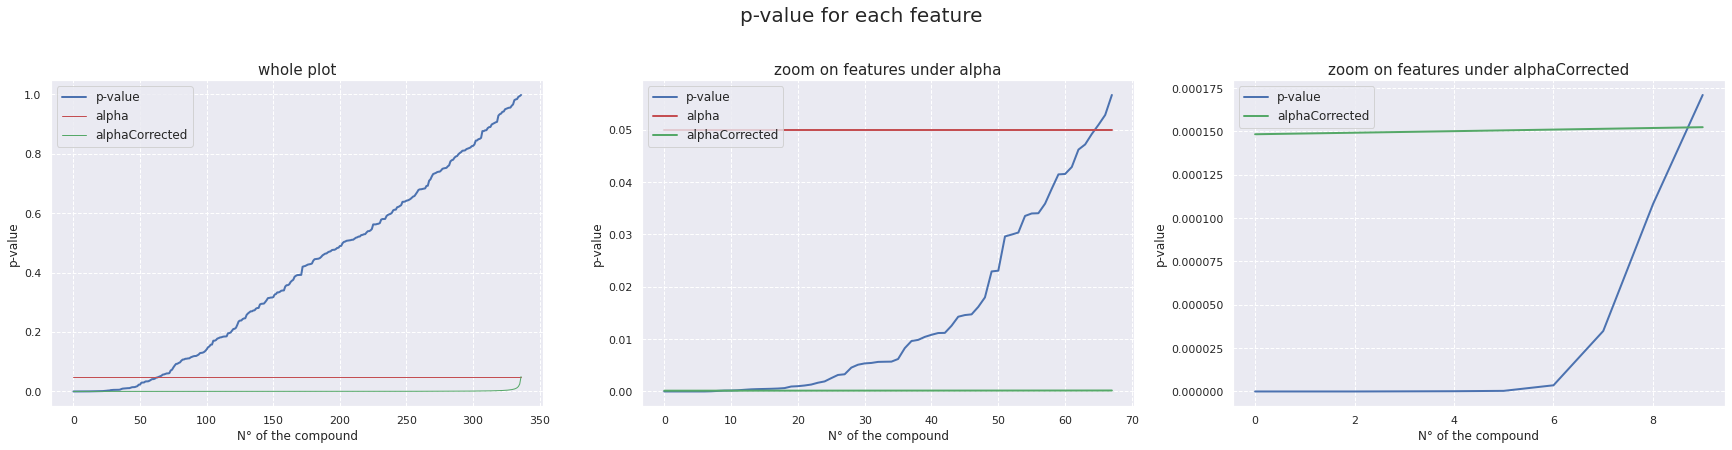

In [58]:
plot_pvalue(test_result3)

Here is the barplot of the number of features with are significantly differentially distributed (True) or not (False).

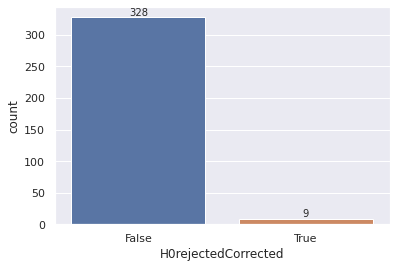

In [59]:
ax = sns.countplot(x='H0rejectedCorrected', data=test_result3);
ax.bar_label(ax.containers[0]);

Below are the features which have a significant difference between Incident and Non-case groups.

In [60]:
test_result3[test_result3['H0rejectedCorrected'] == True]

NormallyDistributed    TestApplied    statistic        pvalue  \
Variable                                                                      
variable_455                 True  Paired t-test     4.937208  3.572263e-06   
variable_1587                True  Paired t-test    -5.853069  7.357586e-08   
variable_1667                True  Paired t-test    -6.822675  9.279162e-10   
variable_1674                True  Paired t-test    -5.685114  1.528873e-07   
variable_1800                True  Paired t-test    -4.385774  3.487572e-05   
variable_2013                True  Paired t-test    -6.955168  1.126615e-09   
variable_2141                True  Paired t-test    -5.485787  3.598747e-07   
variable_2167               False       Wilcoxon  1175.000000  1.080234e-04   
variable_2196                True  Paired t-test    -6.697179  1.924239e-09   

               alpha  H0rejected  Rank  alphaCorrected  H0rejectedCorrected  
Variable                                                                     
variable_455    0.05        True   331        0.000151                 True  
variable_1587   0.05        True   334        0.000150                 True  
variable_1667   0.05        True   337        0.000148                 True  
variable_1674   0.05        True   333        0.000150                 True  
variable_1800   0.05        True   330        0.000152                 True  
variable_2013   0.05        True   336        0.000149                 True  
variable_2141   0.05        True   332        0.000151                 True  
variable_2167   0.05        True   329        0.000152                 True  
variable_2196   0.05        True   335        0.000149                 True

In [61]:
list(test_result3[test_result3['H0rejectedCorrected'] == True].index)

['variable_455',
 'variable_1587',
 'variable_1667',
 'variable_1674',
 'variable_1800',
 'variable_2013',
 'variable_2141',
 'variable_2167',
 'variable_2196']

We will explore later with an other function to which biological compounds these features correspond !

## Test with Benjamini-Hochberg correction

In [62]:
test_result4 = pvalue_correction(df = test_result, correction = 'Benjamini-Hochberg', alpha = 0.01)
test_result4

NormallyDistributed    TestApplied    statistic    pvalue  \
Variable                                                                  
variable_3                  False       Wilcoxon  1270.000000  0.000452   
variable_5                   True  Paired t-test     2.644733  0.009630   
variable_6                  False       Wilcoxon  2082.000000  0.691685   
variable_8                   True  Paired t-test    -1.091111  0.280671   
variable_10                  True  Paired t-test    -1.994325  0.049177   
...                           ...            ...          ...       ...   
variable_2340                True  Paired t-test    -0.059732  0.952666   
variable_2350                True  Paired t-test    -0.091754  0.927432   
variable_2364                True  Paired t-test     0.494443  0.623698   
variable_2365                True  Paired t-test     1.208598  0.235406   
variable_2370                True  Paired t-test    -0.157771  0.875473   

               alpha  H0rejected  Rank  alphaCorrected  H0rejectedCorrected  
Variable                                                                     
variable_3      0.01        True    15        0.000445                False  
variable_5      0.01        True    38        0.001128                False  
variable_6      0.01       False   267        0.007923                False  
variable_8      0.01       False   139        0.004125                False  
variable_10     0.01       False    65        0.001929                False  
...              ...         ...   ...             ...                  ...  
variable_2340   0.01       False   327        0.009703                False  
variable_2350   0.01       False   320        0.009496                False  
variable_2364   0.01       False   246        0.007300                False  
variable_2365   0.01       False   125        0.003709                False  
variable_2370   0.01       False   308        0.009139                False  

[337 rows x 9 columns]

In [63]:
print(f'Before correction, {sum(test_result4["H0rejected"]) / test_result4.shape[0] * 100 :.1f}% \
of features are significantly differentially distributed ({sum(test_result4["H0rejected"])} features).')
print(f'After correction, {sum(test_result4["H0rejectedCorrected"]) / test_result4.shape[0] * 100 :.1f}% \
of features are still significantly differentially distributed ({sum(test_result4["H0rejectedCorrected"])} features).')
print(f'We will explore later with an other function to which biological compounds these \
{sum(test_result4["H0rejectedCorrected"])} features correspond !')
print()
print(f'{test_result4[(test_result4["H0rejected"] == True) & (test_result4["H0rejectedCorrected"] == False)].shape[0]} \
features were significant before but not after the correction, for example the following five features :')

Before correction, 11.6% of features are significantly differentially distributed (39 features).
After correction, 4.2% of features are still significantly differentially distributed (14 features).
We will explore later with an other function to which biological compounds these 14 features correspond !

25 features were significant before but not after the correction, for example the following five features :


Below we can observe the pvalue for each feature, zooming on features which have a pvalue lower than *alpha* and *alphaCorrected*.

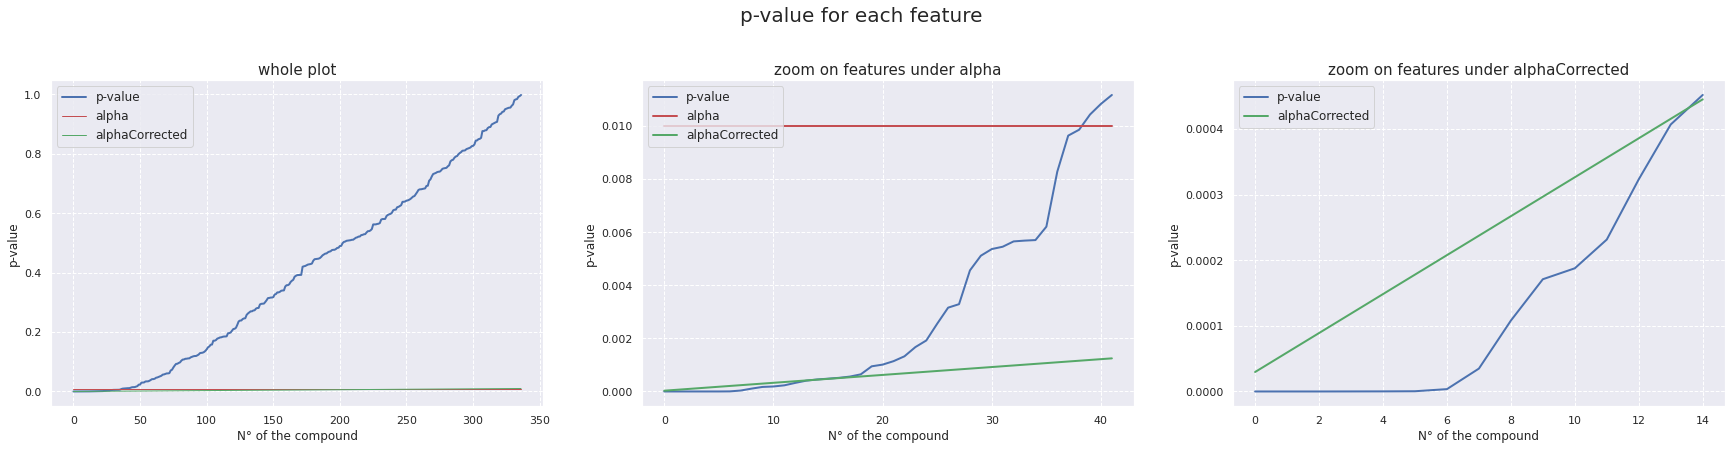

In [64]:
plot_pvalue(test_result4)

Here is the barplot of the number of features with are significantly differentially distributed (True) or not (False).

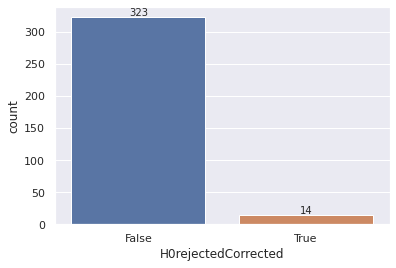

In [65]:
ax = sns.countplot(x='H0rejectedCorrected', data=test_result4);
ax.bar_label(ax.containers[0]);

Below are the features which have a significant difference between Incident and Non-case groups.

In [66]:
test_result4[test_result4['H0rejectedCorrected'] == True]

NormallyDistributed    TestApplied    statistic        pvalue  \
Variable                                                                      
variable_455                 True  Paired t-test     4.937208  3.572263e-06   
variable_1224                True  Paired t-test     3.946625  4.068049e-04   
variable_1582                True  Paired t-test    -3.892422  1.877026e-04   
variable_1587                True  Paired t-test    -5.853069  7.357586e-08   
variable_1667                True  Paired t-test    -6.822675  9.279162e-10   
variable_1674                True  Paired t-test    -5.685114  1.528873e-07   
variable_1681                True  Paired t-test    -3.843810  2.314764e-04   
variable_1800                True  Paired t-test    -4.385774  3.487572e-05   
variable_2013                True  Paired t-test    -6.955168  1.126615e-09   
variable_2141                True  Paired t-test    -5.485787  3.598747e-07   
variable_2167               False       Wilcoxon  1175.000000  1.080234e-04   
variable_2175                True  Paired t-test    -3.956688  1.710264e-04   
variable_2176                True  Paired t-test    -3.758742  3.232757e-04   
variable_2196                True  Paired t-test    -6.697179  1.924239e-09   

               alpha  H0rejected  Rank  alphaCorrected  H0rejectedCorrected  
Variable                                                                     
variable_455    0.01        True     7        0.000208                 True  
variable_1224   0.01        True    14        0.000415                 True  
variable_1582   0.01        True    11        0.000326                 True  
variable_1587   0.01        True     4        0.000119                 True  
variable_1667   0.01        True     1        0.000030                 True  
variable_1674   0.01        True     5        0.000148                 True  
variable_1681   0.01        True    12        0.000356                 True  
variable_1800   0.01        True     8        0.000237                 True  
variable_2013   0.01        True     2        0.000059                 True  
variable_2141   0.01        True     6        0.000178                 True  
variable_2167   0.01        True     9        0.000267                 True  
variable_2175   0.01        True    10        0.000297                 True  
variable_2176   0.01        True    13        0.000386                 True  
variable_2196   0.01        True     3        0.000089                 True

In [67]:
list(test_result4[test_result4['H0rejectedCorrected'] == True].index)

['variable_455',
 'variable_1224',
 'variable_1582',
 'variable_1587',
 'variable_1667',
 'variable_1674',
 'variable_1681',
 'variable_1800',
 'variable_2013',
 'variable_2141',
 'variable_2167',
 'variable_2175',
 'variable_2176',
 'variable_2196']

We will explore later with an other function to which biological compounds these features correspond !

## Test with FDR correction

In [68]:
test_result5 = pvalue_correction(df = test_result, correction = 'FDR', alpha = 0.01)
test_result5

NormallyDistributed    TestApplied    statistic    pvalue  \
Variable                                                                  
variable_3                  False       Wilcoxon  1270.000000  0.000452   
variable_5                   True  Paired t-test     2.644733  0.009630   
variable_6                  False       Wilcoxon  2082.000000  0.691685   
variable_8                   True  Paired t-test    -1.091111  0.280671   
variable_10                  True  Paired t-test    -1.994325  0.049177   
...                           ...            ...          ...       ...   
variable_2340                True  Paired t-test    -0.059732  0.952666   
variable_2350                True  Paired t-test    -0.091754  0.927432   
variable_2364                True  Paired t-test     0.494443  0.623698   
variable_2365                True  Paired t-test     1.208598  0.235406   
variable_2370                True  Paired t-test    -0.157771  0.875473   

               alpha  H0rejected  pvalueCorrected  H0rejectedCorrected  
Variable                                                                
variable_3      0.01        True         0.010144                False  
variable_5      0.01        True         0.085127                False  
variable_6      0.01       False         0.873025                False  
variable_8      0.01       False         0.675987                False  
variable_10     0.01       False         0.254963                False  
...              ...         ...              ...                  ...  
variable_2340   0.01       False         0.977560                False  
variable_2350   0.01       False         0.976702                False  
variable_2364   0.01       False         0.854415                False  
variable_2365   0.01       False         0.633050                False  
variable_2370   0.01       False         0.951837                False  

[337 rows x 8 columns]

In [69]:
print(f'Before correction, {sum(test_result5["H0rejected"]) / test_result5.shape[0] * 100 :.1f}% \
of features are significantly differentially distributed ({sum(test_result5["H0rejected"])} features).')
print(f'After correction, {sum(test_result5["H0rejectedCorrected"]) / test_result5.shape[0] * 100 :.1f}% \
of features are still significantly differentially distributed ({sum(test_result5["H0rejectedCorrected"])} features).')
print(f'We will explore later with an other function to which biological compounds these \
{sum(test_result5["H0rejectedCorrected"])} features correspond !')
print()
print(f'{test_result5[(test_result5["H0rejected"] == True) & (test_result5["H0rejectedCorrected"] == False)].shape[0]} \
features were significant before but not after the correction, for example the following five features :')

Before correction, 11.6% of features are significantly differentially distributed (39 features).
After correction, 4.2% of features are still significantly differentially distributed (14 features).
We will explore later with an other function to which biological compounds these 14 features correspond !

25 features were significant before but not after the correction, for example the following five features :


Below we can observe the pvalue for each feature, zooming on features which have a pvalue lower than *alpha* and *alphaCorrected*.

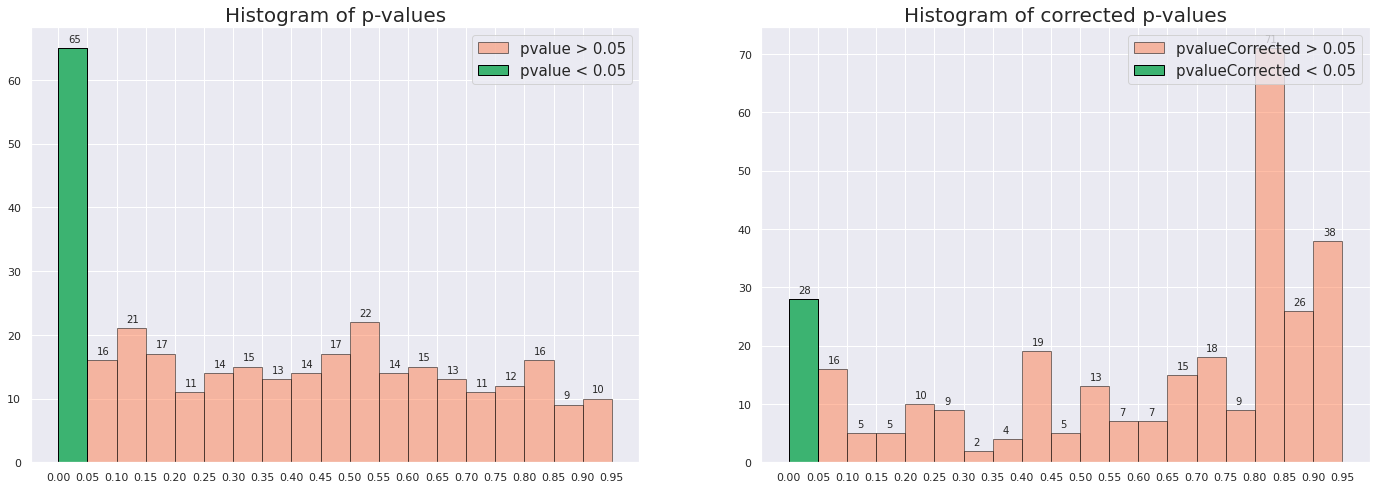

In [70]:
plot_hist_pvalue(test_result5, 0.05, plot_corrected=True)

Here is the barplot of the number of features with are significantly differentially distributed (True) or not (False).

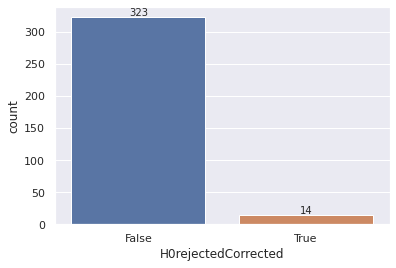

In [71]:
ax = sns.countplot(x='H0rejectedCorrected', data=test_result5);
ax.bar_label(ax.containers[0]);

Below are the features which have a significant difference between Incident and Non-case groups.

In [72]:
test_result5[test_result5['H0rejectedCorrected'] == True]

NormallyDistributed    TestApplied    statistic        pvalue  \
Variable                                                                      
variable_455                 True  Paired t-test     4.937208  3.572263e-06   
variable_1224                True  Paired t-test     3.946625  4.068049e-04   
variable_1582                True  Paired t-test    -3.892422  1.877026e-04   
variable_1587                True  Paired t-test    -5.853069  7.357586e-08   
variable_1667                True  Paired t-test    -6.822675  9.279162e-10   
variable_1674                True  Paired t-test    -5.685114  1.528873e-07   
variable_1681                True  Paired t-test    -3.843810  2.314764e-04   
variable_1800                True  Paired t-test    -4.385774  3.487572e-05   
variable_2013                True  Paired t-test    -6.955168  1.126615e-09   
variable_2141                True  Paired t-test    -5.485787  3.598747e-07   
variable_2167               False       Wilcoxon  1175.000000  1.080234e-04   
variable_2175                True  Paired t-test    -3.956688  1.710264e-04   
variable_2176                True  Paired t-test    -3.758742  3.232757e-04   
variable_2196                True  Paired t-test    -6.697179  1.924239e-09   

               alpha  H0rejected  pvalueCorrected  H0rejectedCorrected  
Variable                                                                
variable_455    0.01        True     1.719790e-04                 True  
variable_1224   0.01        True     9.792376e-03                 True  
variable_1582   0.01        True     5.750525e-03                 True  
variable_1587   0.01        True     6.198766e-06                 True  
variable_1667   0.01        True     1.898347e-07                 True  
variable_1674   0.01        True     1.030460e-05                 True  
variable_1681   0.01        True     6.500628e-03                 True  
variable_1800   0.01        True     1.469140e-03                 True  
variable_2013   0.01        True     1.898347e-07                 True  
variable_2141   0.01        True     2.021296e-05                 True  
variable_2167   0.01        True     4.044878e-03                 True  
variable_2175   0.01        True     5.750525e-03                 True  
variable_2176   0.01        True     8.380300e-03                 True  
variable_2196   0.01        True     2.161562e-07                 True

In [73]:
list(test_result5[test_result5['H0rejectedCorrected'] == True].index)

['variable_455',
 'variable_1224',
 'variable_1582',
 'variable_1587',
 'variable_1667',
 'variable_1674',
 'variable_1681',
 'variable_1800',
 'variable_2013',
 'variable_2141',
 'variable_2167',
 'variable_2175',
 'variable_2176',
 'variable_2196']

We will explore later with an other function to which biological compounds these features correspond !

# Explore variables with are significantly differentially distributed between _Incident_ and _Non-case_

### Below is the subset of the paired test results after correction

In [74]:
test_result4[test_result4['H0rejectedCorrected'] == True]

NormallyDistributed    TestApplied    statistic        pvalue  \
Variable                                                                      
variable_455                 True  Paired t-test     4.937208  3.572263e-06   
variable_1224                True  Paired t-test     3.946625  4.068049e-04   
variable_1582                True  Paired t-test    -3.892422  1.877026e-04   
variable_1587                True  Paired t-test    -5.853069  7.357586e-08   
variable_1667                True  Paired t-test    -6.822675  9.279162e-10   
variable_1674                True  Paired t-test    -5.685114  1.528873e-07   
variable_1681                True  Paired t-test    -3.843810  2.314764e-04   
variable_1800                True  Paired t-test    -4.385774  3.487572e-05   
variable_2013                True  Paired t-test    -6.955168  1.126615e-09   
variable_2141                True  Paired t-test    -5.485787  3.598747e-07   
variable_2167               False       Wilcoxon  1175.000000  1.080234e-04   
variable_2175                True  Paired t-test    -3.956688  1.710264e-04   
variable_2176                True  Paired t-test    -3.758742  3.232757e-04   
variable_2196                True  Paired t-test    -6.697179  1.924239e-09   

               alpha  H0rejected  Rank  alphaCorrected  H0rejectedCorrected  
Variable                                                                     
variable_455    0.01        True     7        0.000208                 True  
variable_1224   0.01        True    14        0.000415                 True  
variable_1582   0.01        True    11        0.000326                 True  
variable_1587   0.01        True     4        0.000119                 True  
variable_1667   0.01        True     1        0.000030                 True  
variable_1674   0.01        True     5        0.000148                 True  
variable_1681   0.01        True    12        0.000356                 True  
variable_1800   0.01        True     8        0.000237                 True  
variable_2013   0.01        True     2        0.000059                 True  
variable_2141   0.01        True     6        0.000178                 True  
variable_2167   0.01        True     9        0.000267                 True  
variable_2175   0.01        True    10        0.000297                 True  
variable_2176   0.01        True    13        0.000386                 True  
variable_2196   0.01        True     3        0.000089                 True

### Below is the subset of the original peak table with only the columns which are significantly differentially distributed between _Incident_ and _Non-case_

In [75]:
subset_X = X[test_result4[test_result4['H0rejectedCorrected'] == True].index]
subset_X

variable_455  variable_1224  variable_1582  variable_1587  variable_1667  \
0       14.901102      11.776399      23.193580      22.727159      21.323783   
1       13.742697            NaN      23.309319      22.852766      21.976711   
2       14.248796      12.889435      22.140140      22.141968      20.243623   
3       14.237655      12.406618      23.152943      22.946740      20.919862   
4       15.256830      13.183449      22.374462      22.107158      19.791554   
..            ...            ...            ...            ...            ...   
181     13.694057            NaN      22.715137      22.543090      21.756619   
182     15.459569      11.859027      22.528103      22.059927      20.736121   
183     15.456830            NaN      22.761386      22.218538      20.888653   
184     14.275241            NaN      22.050695      22.113462      20.669607   
185     12.801153            NaN      22.328270      21.763159      21.610507   

     variable_1674  variable_1681  variable_1800  variable_2013  \
0        20.524991      16.718552      14.323164      13.973290   
1        20.288004      17.138026      14.460135      13.532489   
2        19.234748      15.876230      13.621373      13.701981   
3        20.295436      16.846700      14.624331      13.764644   
4        19.077569      15.802826      13.769721      12.445936   
..             ...            ...            ...            ...   
181      20.527349      16.760570      12.753340      13.285125   
182      19.839717      16.096347      12.700758      12.951560   
183      19.858358      16.002179      12.678920      13.149555   
184      19.402183      15.879798      12.772960      12.779032   
185      19.932413      15.984992      12.233614            NaN   

     variable_2141  variable_2167  variable_2175  variable_2176  variable_2196  
0        15.986642      14.104599      13.998148      12.920181      14.564683  
1        16.890236      14.538937      14.417000      13.434169      14.612778  
2        16.150009      14.309805      14.171836      13.108371      14.480289  
3        15.888334      14.393094      14.025200      13.060972      14.682792  
4        15.201124      14.677153      14.036792      13.047628      14.367795  
..             ...            ...            ...            ...            ...  
181      15.012310      14.342794      13.917362      13.037318      13.868378  
182      14.881942      14.620406      13.868587      13.137159      14.253054  
183      15.498081      14.557569      14.161382      13.114331      14.434996  
184      14.866505      14.582893      14.124636      13.004613      14.287804  
185      15.371037      15.093260      14.803718      13.832269      14.631309  

[186 rows x 14 columns]

### Here we check if the variables have missing values

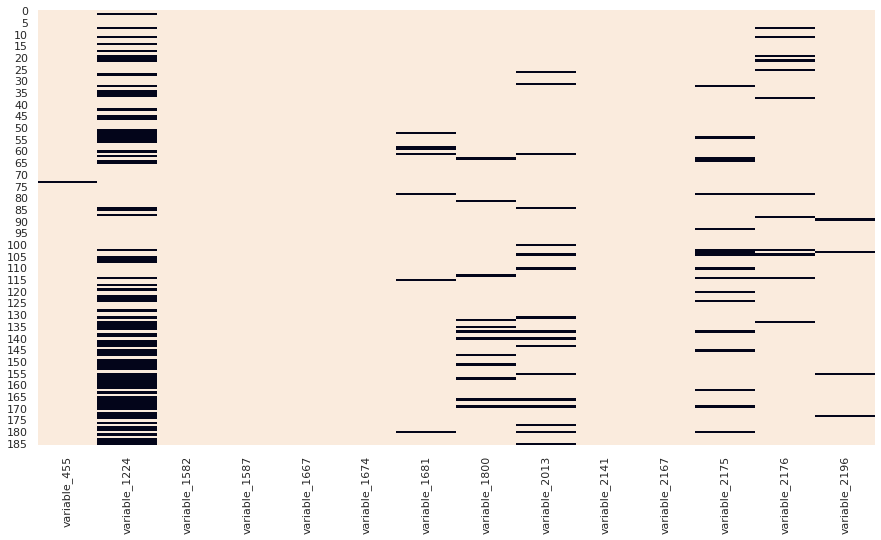

In [76]:
plt.figure(figsize=(15,8))
sns.heatmap(subset_X.notna(), cbar=False);

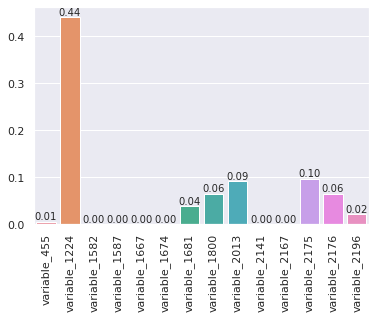

In [77]:
ax = sns.barplot(x=(subset_X.isna().sum()/len(subset_X)).index, y=(subset_X.isna().sum()/len(subset_X)).values);
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0], fmt='%.2f');

It would be better for further analysis to keep only features with less than a certain percent of missing value.

### Here we check if the variables have been identified using metaboigniter

In [78]:
variable_identification = pd.read_csv(pwd + 'data/HILIC_POS_results/process_output_quantid_pos_camera_metfrag/varsPOSout_pos_metfrag.txt', sep='\t', decimal='.', na_values='NA')
variable_identification

variableMetadata  parentMZ  parentRT  Score  MonoisotopicMass  \
0         variable_3   61.0398    93.949    2.0         60.032363   
1         variable_5   62.0601   276.539    2.0         61.052764   
2         variable_6  140.0682   304.407    2.0        117.078979   
3         variable_7  140.0682   304.407    2.0        117.078979   
4         variable_8   61.0398    93.949    2.0         60.032363   
..               ...       ...       ...    ...               ...   
552    variable_2365  288.2907    58.514    2.0        270.255880   
553    variable_2368  140.0682   304.407    2.0        117.078979   
554    variable_2370  288.2907    58.514    2.0        270.255880   
555    variable_2375  140.0682   304.407    2.0        117.078979   
556    variable_2379  140.0682   304.407    2.0        117.078979   

                     SMILES                     InChIKey  \
0                   NC(N)=O  XSQUKJJJFZCRTK-UHFFFAOYSA-N   
1                      NCCO  HZAXFHJVJLSVMW-UHFFFAOYSA-N   
2               NCCCCC(O)=O  JJMDCOVWQOJGCB-UHFFFAOYSA-N   
3               NCCCCC(O)=O  JJMDCOVWQOJGCB-UHFFFAOYSA-N   
4                   NC(N)=O  XSQUKJJJFZCRTK-UHFFFAOYSA-N   
..                      ...                          ...   
552  CCCCCCCCCCCCCCCCC(O)=O  KEMQGTRYUADPNZ-UHFFFAOYSA-N   
553             NCCCCC(O)=O  JJMDCOVWQOJGCB-UHFFFAOYSA-N   
554  CCCCCCCCCCCCCCCCC(O)=O  KEMQGTRYUADPNZ-UHFFFAOYSA-N   
555             NCCCCC(O)=O  JJMDCOVWQOJGCB-UHFFFAOYSA-N   
556             NCCCCC(O)=O  JJMDCOVWQOJGCB-UHFFFAOYSA-N   

                        Name  NoExplPeaks  NumberPeaksUsed  ...  \
0                       Urea           31               52  ...   
1               Ethanolamine           40              175  ...   
2    delta-Aminovaleric acid          115              287  ...   
3    delta-Aminovaleric acid          115              287  ...   
4                       Urea           31               52  ...   
..                       ...          ...              ...  ...   
552     Margaric acid (17:0)          136              392  ...   
553  delta-Aminovaleric acid          115              287  ...   
554     Margaric acid (17:0)          136              392  ...   
555  delta-Aminovaleric acid          115              287  ...   
556  delta-Aminovaleric acid          115              287  ...   

    xcmsCamera_mzmin  xcmsCamera_mzmax  xcmsCamera_rt xcmsCamera_rtmin  \
0          61.039608         61.039794        93.3840           92.664   
1          62.059914         62.060261       275.0040          273.825   
2          64.015582         64.016015       299.3860          195.740   
3          65.018672         65.019122       299.3890          276.857   
4          65.018564         65.019229        93.3840           39.738   
..               ...               ...            ...              ...   
552      1109.058605       1109.063525        64.1250           63.258   
553      1110.784086       1110.788437       299.6370          298.698   
554      1129.561770       1129.566054        62.9080           62.039   
555      1144.776441       1144.781069       299.9940          298.776   
556      1178.771129       1178.775673       299.8395          298.709   

    xcmsCamera_rtmax xcmsCamera_npeaks xcmsCamera_isotopes xcmsCamera_adduct  \
0             94.640               211                 NaN               NaN   
1            275.644               210                 NaN               NaN   
2            317.234               272             [1][M]+               NaN   
3            300.455               213           [1][M+1]+               NaN   
4             94.640               154                 NaN               NaN   
..               ...               ...                 ...               ...   
552           64.813               111                 NaN               NaN   
553          300.660               179                 NaN               NaN   
554           63.575               123  

In [79]:
np.unique(variable_identification['Name'])

array(['1-Amino-2-propanol', '2-Methylbutyrylcarnitine',
       '2-Oxoglutaric acid', '3-Dehydrocarnitine',
       '3-Methyl-2-oxovaleric acid', '3-Methylglutarylcarnitine',
       '3-O-Methyldopamine', '3-Pyridylacetic acid',
       '4-Hydroxybutyric acid', '4-Hydroxycyclohexylacetic acid',
       '4-Hydroxyproline betaine', '4-Pyridoxic acid',
       '5-Aminovaleric acid betaine', '5-Hydroxyindole-3-acetic acid',
       'Acetylcarnitine', 'Behenic acid (22:0)', 'Caffeine',
       'Caproic acid (6:0)', 'Cotinine', 'Creatine', 'Ethanolamine',
       'Glutamine', 'Guaiacol', 'Hypoxanthine', 'Inosine',
       'Leucylproline', 'Lysophosphatidylcholine C20:4', 'Mandelic acid',
       'Margaric acid (17:0)', 'Methionine', 'Myristic acid (14:0)',
       'N-Methylnicotinamide', 'N1-Acetylspermidine', 'Nicotinic acid',
       'Nt-Methylhistamine', 'Octenoylcarnitine', 'Orotic acid',
       'Phenylacetylglutamine', 'Phenylpyruvic acid', 'Pipecolic acid',
       'Proline', 'Proline betaine', 'Pr

#### Subset variable_identification to keep only one variable for each compound (the one with less missing values)

In [80]:
subset_variable_identification_variables = []
for compound in np.unique(variable_identification['Name']):
    variables = variable_identification[variable_identification['Name'] == compound]['variableMetadata'].values
    variables_bool = [var in X.columns for var in variables]
    variables = variables[variables_bool]
    subset_variable_identification_variables.append(X[variables].isna().sum().idxmin())

In [81]:
subset_variable_identification = variable_identification[variable_identification['variableMetadata']\
                                                         .isin(subset_variable_identification_variables)]
#subset_variable_identification = subset_variable_identification[['MonoisotopicMass', 'SMILES', 'InChIKey',
#                                                                 'Name', 'InChI', 'Identifier']]
print(subset_variable_identification.shape)
subset_variable_identification

(54, 34)


variableMetadata  parentMZ  parentRT     Score  MonoisotopicMass  \
0         variable_3   61.0398    93.949  2.000000         60.032363   
1         variable_5   62.0601   276.539  2.000000         61.052764   
2         variable_6  140.0682   304.407  2.000000        117.078979   
5        variable_10  116.0708   308.810  2.000000        115.063329   
6        variable_11   72.0808   304.796  2.000000         71.073499   
7        variable_14   76.0757   232.379  2.000000         75.068414   
9        variable_23  150.0585    89.870  2.000000        149.051049   
12       variable_30  288.2907    58.514  2.000000        270.255880   
13       variable_31   90.0551   351.642  2.000000         89.047678   
19       variable_56  104.0704   331.216  1.936123        103.063329   
23       variable_66  155.1184    44.205  2.000000        137.084064   
26       variable_84  179.0048   275.970  2.000000        156.017107   
30       variable_95  142.0863   138.261  1.991109        124.052429   
34      variable_100  164.1029   111.588  2.000000        146.069142   
36      variable_106  122.0809   274.849  2.000000        104.047344   
40      variable_121  126.1025   280.249  2.000000        125.095297   
42      variable_131  130.0862   264.373  2.000000        129.078979   
45      variable_139  132.0771   354.176  2.000000        131.069477   
46      variable_141  209.0928   264.888  2.000000        191.058243   
51      variable_151  134.1176   181.608  2.000000        116.083730   
52      variable_152  290.1605   121.863  2.000000        289.152537   
58      variable_161  137.0712   224.434  2.000000        136.063663   
60      variable_165  138.0551   285.402  1.797240        137.047678   
65      variable_177  141.0658   343.188  2.000000        123.032028   
68      variable_186  182.0582   264.672  2.000000        143.094629   
73      variable_195  182.0801   314.198  1.919128        164.047344   
75      variable_197  229.1551   315.424  2.000000        228.147393   
77      variable_200  147.0765   388.761  2.000000        129.042593   
97      variable_267  160.1333   272.653  2.000000        159.125929   
107     variable_327  176.1279   351.134  2.000000        158.094294   
115     variable_352  181.0722    60.953  2.000000        180.064726   
120     variable_368  184.0608    77.772  2.000000        183.053158   
121     variable_373  184.9855   475.367  2.000000        146.021523   
123     variable_377  148.0972   305.912  1.970626        130.062994   
131     variable_392  188.1759   414.303  2.000000        187.168462   
150     variable_455  126.0218   320.463  2.000000        125.014664   
152     variable_460  204.1238   288.650  2.000000        203.115758   
169     variable_516  218.1391   253.405  2.000000        217.131408   
176     variable_541  160.0970    80.364  2.000000        159.089543   
186     variable_577  287.1001   218.015  2.000000        264.111007   
200     variable_632  246.1706   188.701  2.000000        245.162708   
208     variable_683  195.0886    49.492  2.000000        194.080376   
209     variable_690  269.1278   163.975  2.000000        246.136828   
217     variable_731  269.0888   211.830  2.000000        268.080770   
231     variable_807  286.2019   131.520  2.000000        285.194008   
235     variable_821  160.0968   340.771  1.798688        159.089543   
261     variable_953  729.5907   102.910  2.000000        728.583225   
290    variable_1118  358.3686    57.705  2.000000        340.334131   
315    variable_1245  170.0814    82.849  1.855852        152.047344   
321    variable_1283  177.1028    56.776  1.922234        176.094963   
387    variable_1587  582.2960   140.235  2.000000        543.332489   
405    variable_1687  137.0462   134.872  2.000000        136.038511   
458    variable_1996  267.1725    39.447  2.000000        228.208930   
470    variable_2071  185.1292    66.808  2.000000        167.094629   

                                           

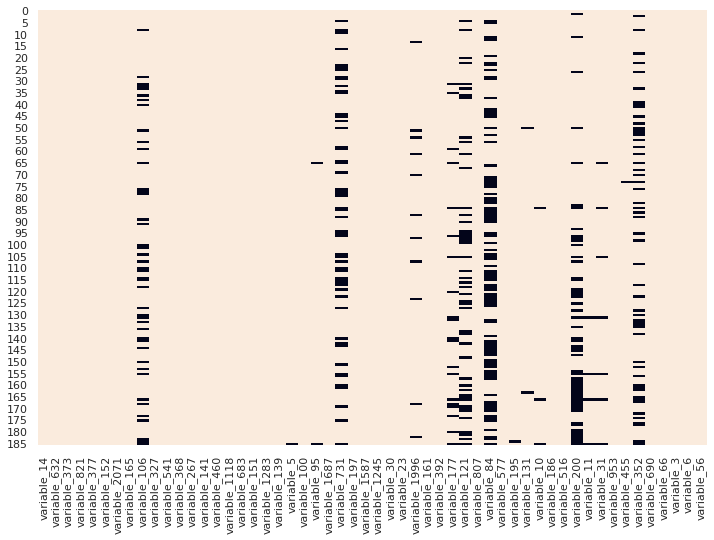

In [82]:
plt.figure(figsize=(12,8))
sns.heatmap(X[subset_variable_identification_variables].notna(), cbar=False);

In [83]:
subset_variable_identification.to_csv(pwd + 
                                      'data/identification/subset_original_one_row_per_compound_all_columns.csv',
                                      header=True, index=False)

#### Explore values for columns of isotopes and adducts

#### Isotopes :

In [84]:
pd.DataFrame([re.sub(r'\[[0-9]+\]', '', index)\
 for index in variable_identification['xcmsCamera_isotopes']
              [variable_identification['xcmsCamera_isotopes'].notna()]]).value_counts()

[M]+      113
[M+1]+     91
[M+2]+     25
[M+3]+     13
[M+4]+      3
dtype: int64

In [85]:
variable_identification[variable_identification['xcmsCamera_isotopes'].str.contains('\[M\]+', na=False)]

variableMetadata  parentMZ  parentRT     Score  MonoisotopicMass  \
2         variable_6  140.0682   304.407  2.000000        117.078979   
7        variable_14   76.0757   232.379  2.000000         75.068414   
27       variable_87  116.0708   308.810  2.000000        115.063329   
29       variable_93   72.0808   304.796  2.000000         71.073499   
30       variable_95  142.0863   138.261  1.991109        124.052429   
..               ...       ...       ...       ...               ...   
508    variable_2195  155.1184    44.205  2.000000        137.084064   
515    variable_2206  155.1184    44.205  2.000000        137.084064   
519    variable_2218  155.1184    44.205  2.000000        137.084064   
526    variable_2229  155.1184    44.205  2.000000        137.084064   
542    variable_2327  286.2019   131.520  2.000000        285.194008   

                                             SMILES  \
2                                       NCCCCC(O)=O   
7                                           CC(O)CN   
27                               OC(=O)[C@@H]1CCCN1   
29                                          C1CCNC1   
30                                 COC1=C(O)C=CC=C1   
..                                              ...   
508                               NCCC1=CC=C(O)C=C1   
515                               NCCC1=CC=C(O)C=C1   
519                               NCCC1=CC=C(O)C=C1   
526                               NCCC1=CC=C(O)C=C1   
542  CCCCC\C=C\C(=O)O[C@@H](CC([O-])=O)C[N+](C)(C)C   

                        InChIKey                     Name  NoExplPeaks  \
2    JJMDCOVWQOJGCB-UHFFFAOYSA-N  delta-Aminovaleric acid          115   
7    HXKKHQJGJAFBHI-UHFFFAOYSA-N       1-Amino-2-propanol          141   
27   ONIBWKKTOPOVIA-BYPYZUCNSA-N                  Proline          117   
29   RWRDLPDLKQPQOW-UHFFFAOYSA-N              Pyrrolidine          101   
30   LHGVFZTZFXWLCP-UHFFFAOYSA-N                 Guaiacol          187   
..                           ...                      ...          ...   
508  DZGWFCGJZKJUFP-UHFFFAOYSA-N                 Tyramine           77   
515  DZGWFCGJZKJUFP-UHFFFAOYSA-N                 Tyramine           77   
519  DZGWFCGJZKJUFP-UHFFFAOYSA-N                 Tyramine           77   
526  DZGWFCGJZKJUFP-UHFFFAOYSA-N                 Tyramine           77   
542  LOSHAHDSFZXVCT-LXKVQUBZSA-N        Octenoylcarnitine          288   

     NumberPeaksUsed  ... xcmsCamera_mzmin  xcmsCamera_mzmax  xcmsCamera_rt  \
2                287  ...        64.015582         64.016015       299.3860   
7                789  ...        76.075408         76.075809       232.4145   
27               466  ...       116.070509        116.070923       308.5350   
29               249  ...       118.086041        118.086542       305.4860   
30               353  ...       118.122134        118.122806       132.0625   
..               ...  ...              ...               ...            ...   
508              167  ...       846.444534        846.446844        41.9665   
515              167  ...       851.396858        851.400361        41.8440   
519              167  ...       867.373822        867.376314        41.9610   
526              167  ...       873.451445        873.454582        42.1870   
542              830  ...      1043.701085       1043.704929       142.7520   

    xcmsCamera_rtmin xcmsCamera_rtmax xcmsCamera_npeaks xcmsCamera_isotopes  \
2            195.740          317.234               272             [1][M]+   
7            231.656          233.473               212             [2][M]+   
27           296.346          309.449               223            [11][M]+   
29           291.526          365.847               244            [12][M]+   
30            59.191          179.929               338            [14][M]+   
..               ...              ...               ...                 ...   
508           41.015           42.402               212           [304][M]+   
515     

#### Adducts :

In [86]:
pd.DataFrame([re.sub(r'[0-9]+', '', index)\
 for index in variable_identification['xcmsCamera_adduct']
              [variable_identification['xcmsCamera_adduct'].notna()]]).value_counts()

[M+H]+ .                                 66
[M+K]+ .                                 53
[M+Na]+ .                                45
[M+NH]+ .                                31
[M+K]+ . [M+H]+ .                         5
[M+Na]+ . [M+H]+ .                        5
[M+K]+ . [M+Na]+ .                        3
[M+NH]+ . [M+H]+ .                        3
[M+K]+ . [M+NH]+ .                        2
[M+K]+ . [M+Na]+ . [M+NH]+ . [M+H]+ .     1
[M+Na]+ . [M+NH]+ .                       1
dtype: int64

In [87]:
variable_identification[variable_identification['xcmsCamera_adduct'].notna()]

variableMetadata  parentMZ  parentRT  Score  MonoisotopicMass  \
7        variable_14   76.0757   232.379    2.0         75.068414   
45      variable_139  132.0771   354.176    2.0        131.069477   
52      variable_152  290.1605   121.863    2.0        289.152537   
56      variable_159  137.0462   134.872    2.0        136.038511   
59      variable_162  137.0462   134.872    2.0        136.038511   
..               ...       ...       ...    ...               ...   
542    variable_2327  286.2019   131.520    2.0        285.194008   
546    variable_2334  582.2960   140.235    2.0        543.332489   
547    variable_2339  288.2907    58.514    2.0        270.255880   
548    variable_2340  288.2907    58.514    2.0        270.255880   
551    variable_2364  288.2907    58.514    2.0        270.255880   

                                                SMILES  \
7                                              CC(O)CN   
45                                   CN(CC(O)=O)C(N)=N   
52         CC(CC([O-])=O)CC(=O)OC(CC(O)=O)C[N+](C)(C)C   
56                                  OC1=NC=NC2=C1NC=N2   
59                                  OC1=NC=NC2=C1NC=N2   
..                                                 ...   
542     CCCCC\C=C\C(=O)O[C@@H](CC([O-])=O)C[N+](C)(C)C   
546  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
547                             CCCCCCCCCCCCCCCCC(O)=O   
548                             CCCCCCCCCCCCCCCCC(O)=O   
551                             CCCCCCCCCCCCCCCCC(O)=O   

                        InChIKey                           Name  NoExplPeaks  \
7    HXKKHQJGJAFBHI-UHFFFAOYSA-N             1-Amino-2-propanol          141   
45   CVSVTCORWBXHQV-UHFFFAOYSA-N                       Creatine          136   
52   HFCPFJNSBPQJDP-UHFFFAOYSA-N      3-Methylglutarylcarnitine          436   
56   FDGQSTZJBFJUBT-UHFFFAOYSA-N                   Hypoxanthine          147   
59   FDGQSTZJBFJUBT-UHFFFAOYSA-N                   Hypoxanthine          147   
..                           ...                            ...          ...   
542  LOSHAHDSFZXVCT-LXKVQUBZSA-N              Octenoylcarnitine          288   
546  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4          216   
547  KEMQGTRYUADPNZ-UHFFFAOYSA-N           Margaric acid (17:0)          136   
548  KEMQGTRYUADPNZ-UHFFFAOYSA-N           Margaric acid (17:0)          136   
551  KEMQGTRYUADPNZ-UHFFFAOYSA-N           Margaric acid (17:0)          136   

     NumberPeaksUsed  ... xcmsCamera_mzmin  xcmsCamera_mzmax  xcmsCamera_rt  \
7                789  ...        76.075408         76.075809       232.4145   
45               422  ...       132.076410        132.077071       354.8500   
52              1529  ...       135.002498        135.002886       176.1335   
56               270  ...       137.045476        137.046915       135.4380   
59               270  ...       138.048327        138.049370       135.4390   
..               ...  ...              ...               ...            ...   
542              830  ...      1043.701085       1043.704929       142.7520   
546              985  ...      1047.731083       1047.735342       140.9180   
547              392  ...      1057.523700       1057.528488        62.9060   
548              392  ...      1058.026171       1058.031037        62.9080   
551              392  ...      1108.556269       1108.561070        64.1240   

    xcmsCamera_rtmin xcmsCamera_rtmax xcmsCamera_npeaks xcmsCamera_isotopes  \
7            231.656          233.473               212             [2][M]+   
45           354.212          355.521               211            [17][M]+   
52           173.812          178.693               210                 NaN   
56            83.628          136.378               212            [21][M]+   
59           133.741          136.378               209          [21][M+1]+   
..               ...              ...               ...                 ...   
542          14

### Explore significant features determined with the statistical test

In [88]:
print(f'With the statistical tests, we identified {subset_X.shape[1]} significant features :')
list(subset_X.columns)

With the statistical tests, we identified 14 significant features :


['variable_455',
 'variable_1224',
 'variable_1582',
 'variable_1587',
 'variable_1667',
 'variable_1674',
 'variable_1681',
 'variable_1800',
 'variable_2013',
 'variable_2141',
 'variable_2167',
 'variable_2175',
 'variable_2176',
 'variable_2196']

Below we subset the variable identification table from *metaboigniter* with only the significant features.

In [89]:
subset_variable_identification_signif = variable_identification[variable_identification['variableMetadata'].isin(subset_X)]
subset_variable_identification_signif

variableMetadata  parentMZ  parentRT     Score  MonoisotopicMass  \
150     variable_455  126.0218   320.463  2.000000        125.014664   
310    variable_1224  142.0863   138.261  1.991109        124.052429   
385    variable_1582  286.2019   131.520  2.000000        285.194008   
387    variable_1587  582.2960   140.235  2.000000        543.332489   
399    variable_1667  544.3405   142.010  2.000000        543.332489   
401    variable_1674  582.2960   140.235  2.000000        543.332489   
403    variable_1681  582.2960   140.235  2.000000        543.332489   
439    variable_1800  582.2960   140.235  2.000000        543.332489   
460    variable_2013  729.5907   102.910  2.000000        728.583225   
482    variable_2141  185.1292    66.808  2.000000        167.094629   
498    variable_2167  185.1292    66.808  2.000000        167.094629   
503    variable_2175  185.1292    66.808  2.000000        167.094629   
504    variable_2176  185.1292    66.808  2.000000        167.094629   
509    variable_2196  185.1292    66.808  2.000000        167.094629   

                                                SMILES  \
150                                      NCCS(O)(=O)=O   
310                                   COC1=C(O)C=CC=C1   
385     CCCCC\C=C\C(=O)O[C@@H](CC([O-])=O)C[N+](C)(C)C   
387  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
399  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
401  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
403  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
439  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
460  [H][C@@](COP([O-])(=O)OCC[N+](C)(C)C)(NC(=O)CC...   
482                              COC1=C(O)C=CC(CCN)=C1   
498                              COC1=C(O)C=CC(CCN)=C1   
503                              COC1=C(O)C=CC(CCN)=C1   
504                              COC1=C(O)C=CC(CCN)=C1   
509                              COC1=C(O)C=CC(CCN)=C1   

                        InChIKey                           Name  NoExplPeaks  \
150  XOAAWQZATWQOTB-UHFFFAOYSA-N                        Taurine           43   
310  LHGVFZTZFXWLCP-UHFFFAOYSA-N                       Guaiacol          187   
385  LOSHAHDSFZXVCT-LXKVQUBZSA-N              Octenoylcarnitine          288   
387  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4          216   
399  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4          108   
401  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4          216   
403  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4          216   
439  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4          216   
460  NELGJAUZKNHZLS-NUIAMLAYSA-N     Sphingomyelin (d18:2/18:0)          203   
482  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine           62   
498  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine           62   
503  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine           62   
504  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine           62   
509  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine           62   

     NumberPeaksUsed  ... xcmsCamera_mzmin  xcmsCamera_mzmax  xcmsCamera_rt  \
150              192  ...       203.138880        203.139850       319.5000   
310              353  ...       393.161314        393.165744       132.3910   
385              830  ...       522.356107        522.357371       142.7520   
387              985  ...       524.371161        524.372784       140.3160   
399              363  ...       544.339066        544.341876       139.4625   
401              985  ...       546.353747        546.356612       140.3150   
403              985  ...       548.364603        548.368579       139.7030   
439              985  ...       602.344920        602.348579       140.8840   
460             1304  ...       729.586986        729.591014       104.9590   
482              136  ...       804.551100        804.554637 

In [90]:
subset_variable_identification_signif.to_csv(pwd + 'data/significant_compounds_after_exploration/compounds_significant_infos_all_columns.csv', header=True, index=False)

In [91]:
variable_identification.columns

Index(['variableMetadata', 'parentMZ', 'parentRT', 'Score', 'MonoisotopicMass',
       'SMILES', 'InChIKey', 'Name', 'NoExplPeaks', 'NumberPeaksUsed', 'InChI',
       'OfflineMetFusionScore', 'MaximumTreeDepth', 'Identifier', 'ExplPeaks',
       'InChIKey3', 'InChIKey2', 'InChIKey1', 'FragmenterScore',
       'MolecularFormula', 'FragmenterScore_Values', 'FormulasOfExplPeaks',
       'q.value', 'xcmsCamera_mz', 'xcmsCamera_mzmin', 'xcmsCamera_mzmax',
       'xcmsCamera_rt', 'xcmsCamera_rtmin', 'xcmsCamera_rtmax',
       'xcmsCamera_npeaks', 'xcmsCamera_isotopes', 'xcmsCamera_adduct',
       'xcmsCamera_pcgroup', 'imputed'],
      dtype='object')

Here we keep only relevant columns for further analysis.

In [92]:
subset_variable_signif_infos = subset_variable_identification_signif[['variableMetadata', 'MonoisotopicMass', 'SMILES', 'InChIKey', 'Name', 'InChI', 'Identifier']]
subset_variable_signif_infos

variableMetadata  MonoisotopicMass  \
150     variable_455        125.014664   
310    variable_1224        124.052429   
385    variable_1582        285.194008   
387    variable_1587        543.332489   
399    variable_1667        543.332489   
401    variable_1674        543.332489   
403    variable_1681        543.332489   
439    variable_1800        543.332489   
460    variable_2013        728.583225   
482    variable_2141        167.094629   
498    variable_2167        167.094629   
503    variable_2175        167.094629   
504    variable_2176        167.094629   
509    variable_2196        167.094629   

                                                SMILES  \
150                                      NCCS(O)(=O)=O   
310                                   COC1=C(O)C=CC=C1   
385     CCCCC\C=C\C(=O)O[C@@H](CC([O-])=O)C[N+](C)(C)C   
387  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
399  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
401  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
403  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
439  CCCCC\C=C/C\C=C/C\C=C/C\C=C/CCCC(=O)OC[C@@H](O...   
460  [H][C@@](COP([O-])(=O)OCC[N+](C)(C)C)(NC(=O)CC...   
482                              COC1=C(O)C=CC(CCN)=C1   
498                              COC1=C(O)C=CC(CCN)=C1   
503                              COC1=C(O)C=CC(CCN)=C1   
504                              COC1=C(O)C=CC(CCN)=C1   
509                              COC1=C(O)C=CC(CCN)=C1   

                        InChIKey                           Name  \
150  XOAAWQZATWQOTB-UHFFFAOYSA-N                        Taurine   
310  LHGVFZTZFXWLCP-UHFFFAOYSA-N                       Guaiacol   
385  LOSHAHDSFZXVCT-LXKVQUBZSA-N              Octenoylcarnitine   
387  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4   
399  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4   
401  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4   
403  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4   
439  LAXQYRRMGGEGOH-JXRLJXCWSA-N  Lysophosphatidylcholine C20:4   
460  NELGJAUZKNHZLS-NUIAMLAYSA-N     Sphingomyelin (d18:2/18:0)   
482  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine   
498  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine   
503  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine   
504  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine   
509  DIVQKHQLANKJQO-UHFFFAOYSA-N             3-O-Methyldopamine   

                                                 InChI   Identifier  
150  InChI=1S/C2H7NO3S/c3-1-2-7(4,5)6/h1-3H2,(H,4,5,6)  HMDB0000251  
310   InChI=1S/C7H8O2/c1-9-7-5-3-2-4-6(7)8/h2-5,8H,1H3  HMDB0001398  
385  InChI=1S/C15H27NO4/c1-5-6-7-8-9-10-15(19)20-13...  HMDB0013324  
387  InChI=1S/C28H50NO7P/c1-5-6-7-8-9-10-11-12-13-1...  HMDB0010395  
399  InChI=1S/C28H50NO7P/c1-5-6-7-8-9-10-11-12-13-1...  HMDB0010395  
401  InChI=1S/C28H50NO7P/c1-5-6-7-8-9-10-11-12-13-1...  HMDB0010395  
403  InChI=1S/C28H50NO7P/c1-5-6-7-8-9-10-11-12-13-1...  HMDB0010395  
439  InChI=1S/C28H50NO7P/c1-5-6-7-8-9-10-11-12-13-1...  HMDB0010395  
460  InChI=1S/C41H81N2O6P/c1-6-8-10-12-14-16-18-20-...  HMDB0240631  
482  InChI=1S/C9H13NO2/c1-12-9-6-7(4-5-10)2-3-8(9)1...  HMDB0000022  
498  InChI=1S/C9H13NO2/c1-12-9-6-7(4-5-10)2-3-8(9)1...  HMDB0000022  
503  InChI=1S/C9H13NO2/c1-12-9-6-7(4-5-10)2-3-8(9)1...  HMDB0000022  
504  InChI=1S/C9H13NO2/c1-12-9-6-7(4-5-10)2-3-8(9)1...  HMDB0000022  
509  InChI=1S/C9H13NO2/c1-12-9-6-7(4-5-10)2-3-8(9)1...  HMDB0000022

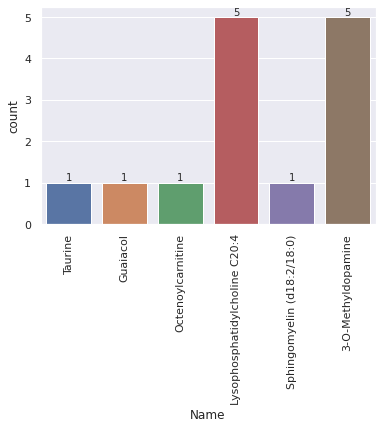

In [93]:
ax = sns.countplot(x='Name', data=subset_variable_signif_infos);
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0]);

In [94]:
subset_variable_signif_infos.to_csv(pwd + 'data/significant_compounds_after_exploration/compounds_significant_infos_relevant_columns.csv', header=True, index=False)

We can observe that some variables correspond to the same compounds.

For example, we can explore the variables corresponding to the compound *Lysophosphatidylcholine C20:4* :

In [95]:
list_variable_lyso = list(subset_variable_signif_infos[subset_variable_signif_infos['Name'] == 'Lysophosphatidylcholine C20:4']
                          ['variableMetadata'].values)
list_variable_lyso

['variable_1587',
 'variable_1667',
 'variable_1674',
 'variable_1681',
 'variable_1800']

In [96]:
X[list_variable_lyso]

variable_1587  variable_1667  variable_1674  variable_1681  variable_1800
0        22.727159      21.323783      20.524991      16.718552      14.323164
1        22.852766      21.976711      20.288004      17.138026      14.460135
2        22.141968      20.243623      19.234748      15.876230      13.621373
3        22.946740      20.919862      20.295436      16.846700      14.624331
4        22.107158      19.791554      19.077569      15.802826      13.769721
..             ...            ...            ...            ...            ...
181      22.543090      21.756619      20.527349      16.760570      12.753340
182      22.059927      20.736121      19.839717      16.096347      12.700758
183      22.218538      20.888653      19.858358      16.002179      12.678920
184      22.113462      20.669607      19.402183      15.879798      12.772960
185      21.763159      21.610507      19.932413      15.984992      12.233614

[186 rows x 5 columns]

Below we can see the correlations between each of the features corresponding to *Lysophosphatidylcholine C20:4* :

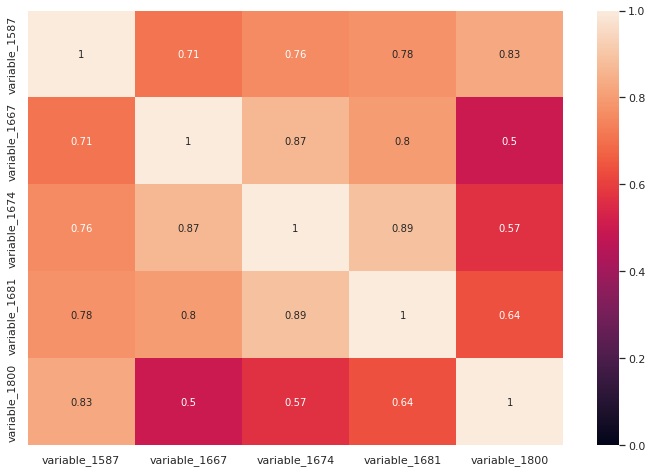

In [97]:
plt.figure(figsize=(12,8))
sns.heatmap(X[list_variable_lyso].corr(),
            annot=True, fmt='.2g', vmin=0, vmax=1);

And here is the list of all the compounds corresponding to significant features :

In [98]:
list(np.unique(variable_identification[variable_identification['variableMetadata'].isin(subset_X)]['Name']))

['3-O-Methyldopamine',
 'Guaiacol',
 'Lysophosphatidylcholine C20:4',
 'Octenoylcarnitine',
 'Sphingomyelin (d18:2/18:0)',
 'Taurine']

### For each significant compound, we only keep the column (variable) with the minimum number of missing values  

In [99]:
comp_signif = variable_identification[variable_identification['variableMetadata'].isin(test_result4[test_result4['H0rejectedCorrected'] == True].index)]
variables_to_keep = []
for compound in np.unique(comp_signif['Name']):
    variables = comp_signif[comp_signif['Name'] == compound]['variableMetadata'].values
    variables_to_keep.append(X[variables].isna().sum().idxmin())
variables_to_keep

['variable_2141',
 'variable_1224',
 'variable_1587',
 'variable_1582',
 'variable_2013',
 'variable_455']

In [100]:
comp_signif_var_name = comp_signif[comp_signif['variableMetadata'].isin(variables_to_keep)][['variableMetadata', 'Name']]
comp_signif_var_name

variableMetadata                           Name
150     variable_455                        Taurine
310    variable_1224                       Guaiacol
385    variable_1582              Octenoylcarnitine
387    variable_1587  Lysophosphatidylcholine C20:4
460    variable_2013     Sphingomyelin (d18:2/18:0)
482    variable_2141             3-O-Methyldopamine

In [101]:
significant_variable = subset_variable_infos[subset_variable_infos['variableMetadata'].isin(variables_to_keep)]
significant_variable

NameError: name 'subset_variable_infos' is not defined

In [ ]:
significant_variable.to_csv(pwd + 'data/significant_compounds_after_exploration/compounds_significant_infos_relevant_columns_one_variable.csv', header=True, index=False)

### Below is the pattern of missing values for the variables that we kept

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(X[variables_to_keep].notna(), cbar=False);

In [ ]:
ax = sns.barplot(x=(X[variables_to_keep].isna().sum()/len(X[variables_to_keep])).index,
                 y=(X[variables_to_keep].isna().sum()/len(X[variables_to_keep])).values);
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0], fmt='%.2f');

It would be better for further analysis to keep only features with less than a certain percent of missing value.

### Below we can see the variable distributions and boxplots corresponding to the TypTumo, for the variables we kept just before

In [ ]:
comp_signif_var_name

In [ ]:
X[variables_to_keep]

In [ ]:
palette = {'Non-case': 'mediumseagreen', 'HCC': 'salmon', 'HCC_Wide': 'gold'}

for col in X[variables_to_keep]:
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=peakTable_copy, x=peakTable_copy[col], hue='TypTumo', hue_order=['Non-case', 'HCC', 'HCC_Wide'], kde=True, element='step', palette=palette)
    plt.title('Histogram')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='TypTumo', y=col, data=peakTable_copy, order=['Non-case', 'HCC', 'HCC_Wide'], palette=palette)
    plt.title('Boxplot')
    
    compound = comp_signif_var_name[comp_signif_var_name['variableMetadata'] == col]
    plt.suptitle(f'{compound.iloc[0]["Name"]} : {col}', fontsize=16)
    
    print(120 * '-')
    
    plt.show()

# Save subset data with only significant variables

In [ ]:
metadata = peakTable.iloc[:, ['variable' not in col for col in peakTable.columns]]
metadata

In [ ]:
X_subset = X[variables_to_keep]
X_subset

In [ ]:
peakTable_subset = pd.concat([metadata, X_subset], axis=1)
peakTable_subset

In [ ]:
peakTable_subset.to_csv(pwd + 'data/peakTable/subset_peakTable/peakTable_subset.csv', header=True, index=False)

# Relative log abundance and Volcano plot will be used later on an imputed and normalised peak table !

## Relative log abundance

In [ ]:
X.shape

In [ ]:
plot_relative_log_abundance(X)

In [ ]:
plot_relative_log_abundance(X_subset)